In [1]:
import polars as pl
df = pl.read_csv("../data/data.csv")

In [2]:
print(df.columns)
print(df.dtypes)

['', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
[Int64, String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64]


# Intervalos anómalos

In [3]:
import datetime 

anomalies = [
    (datetime.datetime(2020, 4, 12, 11, 50), datetime.datetime(2020, 4, 12, 23, 30)),
    (datetime.datetime(2020, 4, 18, 0, 0), datetime.datetime(2020, 4, 18, 23, 59)),
    (datetime.datetime(2020, 4, 19, 0, 0), datetime.datetime(2020, 4, 19, 1, 30)),
    (datetime.datetime(2020, 4, 29, 3, 20), datetime.datetime(2020, 4, 29, 4, 0)),
    (datetime.datetime(2020, 4, 29, 22, 0), datetime.datetime(2020, 4, 29, 22, 20)),
    (datetime.datetime(2020, 5, 13, 14, 0), datetime.datetime(2020, 5, 13, 23, 59)),
    (datetime.datetime(2020, 5, 18, 5, 0), datetime.datetime(2020, 5, 18, 5, 30)),
    (datetime.datetime(2020, 5, 19, 10, 10), datetime.datetime(2020, 5, 19, 11, 0)),
    (datetime.datetime(2020, 5, 19, 22, 10), datetime.datetime(2020, 5, 19, 23, 59)),
    (datetime.datetime(2020, 5, 20, 0, 0), datetime.datetime(2020, 5, 20, 20, 0)),
    (datetime.datetime(2020, 5, 23, 9, 50), datetime.datetime(2020, 5, 23, 10, 10)),
    (datetime.datetime(2020, 5, 29, 23, 30), datetime.datetime(2020, 5, 29, 23, 59)),
    (datetime.datetime(2020, 5, 30, 0, 0), datetime.datetime(2020, 5, 30, 6, 0)),
    (datetime.datetime(2020, 6, 1, 15, 0), datetime.datetime(2020, 6, 1, 15, 40)),
    (datetime.datetime(2020, 6, 3, 10, 0), datetime.datetime(2020, 6, 3, 11, 0)),
    (datetime.datetime(2020, 6, 5, 10, 0), datetime.datetime(2020, 6, 5, 23, 59)),
    (datetime.datetime(2020, 6, 6, 0, 0), datetime.datetime(2020, 6, 6, 23, 59)),
    (datetime.datetime(2020, 6, 7, 0, 0), datetime.datetime(2020, 6, 7, 14, 30)),
    (datetime.datetime(2020, 7, 8, 17, 30), datetime.datetime(2020, 7, 8, 19, 0)),
    (datetime.datetime(2020, 7, 15, 14, 30), datetime.datetime(2020, 7, 15, 19, 0)),
    (datetime.datetime(2020, 7, 17, 4, 30), datetime.datetime(2020, 7, 17, 5, 30)),
]


raros = [
    #NO APARECE COMO ANOMALIA
    (datetime.datetime(2020, 3, 6, 21, 42, 15), datetime.datetime(2020, 3, 6, 23, 14, 0)),
    (datetime.datetime(2020, 3, 11, 5, 15, 10), datetime.datetime(2020, 3, 11, 6, 25, 0)),
    (datetime.datetime(2020, 3, 12, 0, 15, 56), datetime.datetime(2020, 3, 12, 11, 59, 0)),
    (datetime.datetime(2020, 3, 26, 4, 0, 20), datetime.datetime(2020, 3, 26, 5, 20, 0)),
    (datetime.datetime(2020, 3, 27, 7, 12, 0), datetime.datetime(2020, 3, 27, 12, 1, 0)),
    (datetime.datetime(2020, 4, 17, 8, 50, 28), datetime.datetime(2020, 4, 17, 23, 59, 0)),
    (datetime.datetime(2020, 4, 25, 0, 7, 15), datetime.datetime(2020, 4, 25, 1, 10, 0)),
    (datetime.datetime(2020, 5, 19, 1, 35, 28), datetime.datetime(2020, 5, 19, 2, 40, 0)),
    (datetime.datetime(2020, 6, 12, 1, 41, 7), datetime.datetime(2020, 6, 12, 17, 6, 0)),
    (datetime.datetime(2020, 7, 21, 13, 32, 48), datetime.datetime(2020, 7, 21, 22, 3, 0)),
    (datetime.datetime(2020, 7, 22, 6, 40, 46), datetime.datetime(2020, 7, 22, 13, 10, 0)),
    (datetime.datetime(2020, 7, 31, 0, 57, 33), datetime.datetime(2020, 7, 31, 2, 9, 0))
]

anomalies.extend(raros)

# Correción de periodos temporales.
final_anomalies = []
for anomaly in anomalies: 
  new = list(anomaly)
  if anomaly[1].minute == 59:
    new[1] += datetime.timedelta(minutes=1)
  final_anomalies.append(new)

In [4]:
import datetime
df = df.with_columns(pl.col("timestamp").str.to_datetime())
df = df.with_row_index("rownr")

In [5]:
anomalies[1][1] + datetime.timedelta(seconds=59)

datetime.datetime(2020, 4, 18, 23, 59, 59)

# Definimos las anomalias

In [6]:
def is_anomaly(instance_date, anomalies: list[datetime]):
    flag_anomaly = False
    index = 0
    while not flag_anomaly and index < len(anomalies):
        t = anomalies[index]
        if instance_date >= t[0] and instance_date <= t[1] + datetime.timedelta(seconds=59):
            flag_anomaly = True
        index += 1
    return flag_anomaly


df = df.select(pl.all(), pl.lit(0).alias("is_anomaly"))
for anomaly in final_anomalies:
  df = df.with_columns((pl.col("is_anomaly") + df["timestamp"].is_between(anomaly[0], anomaly[1])))
df = df.select(pl.exclude("is_anomaly"), pl.col("is_anomaly") >= 1)
# df = df.select(pl.all(), pl.col("timestamp").map_elements(lambda x: is_anomaly(x, anomalies), return_dtype=pl.Boolean).alias("is_anomaly"))

# Justificamos el cálculo de la ventana

In [7]:
# Create transition states
tdf = df.select(pl.all(), pl.col("is_anomaly").shift(-1).alias("next_is_anomaly"), pl.col("Motor_current").gt(0.05).alias("motor_state"))
tdf = tdf.select(pl.all(), (pl.col("is_anomaly") != pl.col("next_is_anomaly")).alias("transition"))
tdf

shape: (1_516_948, 22)
┌─────────┬──────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ rownr   ┆          ┆ timestamp  ┆ TP2    ┆ … ┆ is_anomaly ┆ next_is_an ┆ motor_stat ┆ transition │
│ ---     ┆ ---      ┆ ---        ┆ ---    ┆   ┆ ---        ┆ omaly      ┆ e          ┆ ---        │
│ u32     ┆ i64      ┆ datetime[μ ┆ f64    ┆   ┆ bool       ┆ ---        ┆ ---        ┆ bool       │
│         ┆          ┆ s]         ┆        ┆   ┆            ┆ bool       ┆ bool       ┆            │
╞═════════╪══════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0        ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1       ┆ 10       ┆ 2020-02-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:10   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2       ┆ 20       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:19   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 3       ┆ 30       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:29   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 4       ┆ 40       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:39   ┆        ┆   ┆            ┆            ┆            ┆            │
│ …       ┆ …        ┆ …          ┆ …      ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 1516943 ┆ 15169430 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:10   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516944 ┆ 15169440 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:20   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516945 ┆ 15169450 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:30   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516946 ┆ 15169460 ┆ 2020-09-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:40   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516947 ┆ 15169470 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ null       ┆ false      ┆ null       │
│         ┆          ┆ 03:59:50   ┆        ┆   ┆            ┆            ┆            ┆            │
└─────────┴──────────┴────────────┴────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [8]:
# Create groups based on transition
tdf = tdf.select(pl.all(), pl.col("transition").cum_sum().alias("groups"))
tdf["groups"].max()

54

In [9]:
gdf = tdf.select(pl.all(), pl.col("groups").shift(-1).alias("next_group"), pl.col("motor_state").shift(-1).alias("next_motor_state"))
# Filter a ON switch
fdf = gdf.filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1)).with_columns(pl.col("timestamp").shift(-1).alias("next_timestamp"))
# Filter out different time groups
fdf = fdf.filter(pl.col("groups") == pl.col("next_group"))
# Calculate the duration
fdf = fdf.with_columns((pl.col("next_timestamp") - pl.col("timestamp")).alias("duration")).filter(pl.col("duration").is_not_null())
print(fdf["duration"].dt.total_seconds().max(), fdf["duration"].dt.total_seconds().min(), fdf["duration"].dt.total_seconds().mean(), fdf["duration"].dt.total_seconds().mode()[0])

274751 19 1771.898393149235 1249


In [10]:
fdf.filter(pl.col("duration").eq(pl.col("duration").max()))

shape: (1, 27)
┌────────┬─────────┬─────────────┬────────┬───┬────────────┬─────────────┬────────────┬────────────┐
│ rownr  ┆         ┆ timestamp   ┆ TP2    ┆ … ┆ next_group ┆ next_motor_ ┆ next_times ┆ duration   │
│ ---    ┆ ---     ┆ ---         ┆ ---    ┆   ┆ ---        ┆ state       ┆ tamp       ┆ ---        │
│ u32    ┆ i64     ┆ datetime[μs ┆ f64    ┆   ┆ u32        ┆ ---         ┆ ---        ┆ duration[μ │
│        ┆         ┆ ]           ┆        ┆   ┆            ┆ bool        ┆ datetime[μ ┆ s]         │
│        ┆         ┆             ┆        ┆   ┆            ┆             ┆ s]         ┆            │
╞════════╪═════════╪═════════════╪════════╪═══╪════════════╪═════════════╪════════════╪════════════╡
│ 890739 ┆ 8907390 ┆ 2020-06-05  ┆ -0.014 ┆ … ┆ 38         ┆ true        ┆ 2020-06-08 ┆ 3d 4h 19m  │
│        ┆         ┆ 09:48:20    ┆        ┆   ┆            ┆             ┆ 14:07:31   ┆ 11s        │
└────────┴─────────┴─────────────┴────────┴───┴────────────┴─────────────┴────────────┴────────────┘

In [11]:
import plotly.express as px
data_anomaly = df.filter(pl.col("timestamp").is_between(
datetime.datetime(2020,6,5,00,00,00), datetime.datetime(2020,6,8,15,00,00)
))
px.line(data_anomaly, x="timestamp", y=["TP3", "Motor_current"])

In [12]:
data_anomaly.select(pl.col("is_anomaly"), pl.col("is_anomaly").shift(-1).alias("next_is_anomaly"), pl.col("timestamp"), pl.col("timestamp").shift(-1).alias("next_timestamp")).filter(~pl.col("is_anomaly").eq(pl.col("next_is_anomaly")))

shape: (2, 4)
┌────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ is_anomaly ┆ next_is_anomaly ┆ timestamp           ┆ next_timestamp      │
│ ---        ┆ ---             ┆ ---                 ┆ ---                 │
│ bool       ┆ bool            ┆ datetime[μs]        ┆ datetime[μs]        │
╞════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ false      ┆ true            ┆ 2020-06-05 09:59:54 ┆ 2020-06-05 10:00:04 │
│ true       ┆ false           ┆ 2020-06-07 14:19:39 ┆ 2020-06-08 11:48:04 │
└────────────┴─────────────────┴─────────────────────┴─────────────────────┘

## Para cada grupo

In [13]:
gdf = tdf.select(pl.all(), pl.col("groups").shift(-1).alias("next_group"), pl.col("motor_state").shift(-1).alias("next_motor_state"))
# Filter a ON switch
durations = []
for label, group in gdf.filter(pl.col("groups") == pl.col("next_group")).group_by("groups"):
  tmp = group.filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1)).with_columns(pl.col("timestamp").shift(-1).alias("next_timestamp"))
  tmp = tmp.with_columns((pl.col("next_timestamp") - pl.col("timestamp")).alias("duration")).filter(pl.col("duration").is_not_null())
  durations += tmp["duration"].to_list()
durations = [x.total_seconds() for x in durations]
print(max(durations), min(durations), sum(durations) / len(durations), durations[len(durations)//2])

224082.0 19.0 1695.8500048323185 1170.0


## Para el primer tramo no-anómalo

In [14]:
subdf = df.filter(pl.col("timestamp").lt(anomalies[0][0]))
subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))["timestamp"].diff().dt.total_seconds().mode()[0]

1586

## Para cada grupo evitando saltos temporales

In [15]:
durations = []
subdf = df.filter(pl.col("timestamp").lt(final_anomalies[0][0]))
subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
print(len(durations), len(subdf))
durations += subdf["duration"].to_list()
for anomaly, next_anomaly, next_next_anomaly in zip(final_anomalies, final_anomalies[1:], final_anomalies[2:]):
  subdf = df.filter(
    (pl.col("timestamp").lt(next_anomaly[0]) & (pl.col("timestamp").gt(anomaly[1])))
  )
  subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
  subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
  subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
  print(len(durations), len(subdf))
  durations += subdf["duration"].to_list()
  subdf = df.filter(
    (pl.col("timestamp").gt(next_anomaly[1]) & (pl.col("timestamp").lt(next_next_anomaly[0])))
  )
  subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
  subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
  subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
  print(len(durations), len(subdf))
  durations += subdf["duration"].to_list()
print(max(durations), min(durations), sum(durations) / len(durations), sorted(durations)[len(durations)//2])

0 3165
3165 147
3312 0
3312 0
3312 311
3623 311
3934 38
3972 38
4010 515
4525 515
5040 182
5222 182
5404 100
5504 100
5604 43
5647 43
5690 0
5690 0
5690 193
5883 193
6076 269
6345 269
6614 0
6614 0
6614 145
6759 145
6904 83
6987 83
7070 115
7185 115
7300 0
7300 0
7300 0
7300 0
7300 1745
9045 1745
10790 379
11169 379
11548 97
11645 97
11742 0
11742 0
11742 230
11972 230
12202 22
12224 22
12246 612
12858 612
13470 53
13523 53
13576 802
14378 802
15180 230
15410 230
15640 902
16542 902
17444 1106
18550 1106
19656 2316
21972 2316
24288 24
24312 24
24336 518
274930 20 1781.5975698076768 1289


In [16]:
df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))

In [17]:
# df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))
df = df.with_columns((pl.col("diff").dt.total_seconds() // (1260 * 2)).alias("id"))
df = df.with_columns(pl.col("id").cast(pl.UInt64).alias("id"))

In [18]:
df.group_by("id", maintain_order=True).len()

shape: (6_232, 2)
┌──────┬─────┐
│ id   ┆ len │
│ ---  ┆ --- │
│ u64  ┆ u32 │
╞══════╪═════╡
│ null ┆ 1   │
│ 0    ┆ 254 │
│ 1    ┆ 254 │
│ 2    ┆ 254 │
│ 3    ┆ 255 │
│ …    ┆ …   │
│ 7297 ┆ 129 │
│ 7303 ┆ 30  │
│ 7306 ┆ 101 │
│ 7307 ┆ 254 │
│ 7308 ┆ 145 │
└──────┴─────┘

In [19]:
import plotly.express as px
import pandas as pd
start = 51000
end = 51000 + 10000
df = df.sort("timestamp")
px.line(df[start : end], x="timestamp", y="TP3", color="id")

Tendríamos que imputar solamente aquellos tramos cuya distancia fuera casi insignificante (algunos minutos). 
Ya que si observamos el Feb-9T00:00 a Feb-9T06:00 hemos introducido una línea similar a lo que seŕia una anomalía por el tamaño del salto temporal.

Otra opción sería investigar introducir segmentos cíclicos hasta que la diferencia fuera manejable. No obstante, esto sería difícil de argumentar y confuso para los posibles segmentos anómalos. 

## Observar valores faltantes

In [20]:
with pl.Config(tbl_rows=1000):
  print(df.filter(pl.col("timestamp").gt(datetime.datetime(2020,2, 1, 19, 40, 00)) & pl.col("timestamp").lt(datetime.datetime(2020, 2, 2, 6, 00, 00))))

shape: (549, 21)
┌───────┬───────┬─────────────────┬────────┬───┬────────────────┬────────────┬───────────────┬─────┐
│ rownr ┆       ┆ timestamp       ┆ TP2    ┆ … ┆ Caudal_impulse ┆ is_anomaly ┆ diff          ┆ id  │
│ ---   ┆ ---   ┆ ---             ┆ ---    ┆   ┆ s              ┆ ---        ┆ ---           ┆ --- │
│ u32   ┆ i64   ┆ datetime[μs]    ┆ f64    ┆   ┆ ---            ┆ bool       ┆ duration[μs]  ┆ u64 │
│       ┆       ┆                 ┆        ┆   ┆ f64            ┆            ┆               ┆     │
╞═══════╪═══════╪═════════════════╪════════╪═══╪════════════════╪════════════╪═══════════════╪═════╡
│ 7113  ┆ 71130 ┆ 2020-02-01      ┆ -0.012 ┆ … ┆ 1.0            ┆ false      ┆ 19h 40m 4s    ┆ 28  │
│       ┆       ┆ 19:40:04        ┆        ┆   ┆                ┆            ┆               ┆     │
│ 7114  ┆ 71140 ┆ 2020-02-01      ┆ -0.018 ┆ … ┆ 1.0            ┆ false      ┆ 23h 15m 33s   ┆ 33  │
│       ┆       ┆ 23:15:33        ┆        ┆   ┆                ┆         

In [21]:
df.filter(pl.col("timestamp").diff().dt.total_seconds().gt(10))

shape: (51_147, 21)
┌─────────┬──────────┬──────────────┬────────┬───┬──────────────┬────────────┬──────────────┬──────┐
│ rownr   ┆          ┆ timestamp    ┆ TP2    ┆ … ┆ Caudal_impul ┆ is_anomaly ┆ diff         ┆ id   │
│ ---     ┆ ---      ┆ ---          ┆ ---    ┆   ┆ ses          ┆ ---        ┆ ---          ┆ ---  │
│ u32     ┆ i64      ┆ datetime[μs] ┆ f64    ┆   ┆ ---          ┆ bool       ┆ duration[μs] ┆ u64  │
│         ┆          ┆              ┆        ┆   ┆ f64          ┆            ┆              ┆      │
╞═════════╪══════════╪══════════════╪════════╪═══╪══════════════╪════════════╪══════════════╪══════╡
│ 4654    ┆ 46540    ┆ 2020-02-01   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 12h 53m 47s  ┆ 18   │
│         ┆          ┆ 12:53:47     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 7114    ┆ 71140    ┆ 2020-02-01   ┆ -0.018 ┆ … ┆ 1.0          ┆ false      ┆ 23h 15m 33s  ┆ 33   │
│         ┆          ┆ 23:15:33     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 7144    ┆ 71440    ┆ 2020-02-02   ┆ 9.952  ┆ … ┆ 1.0          ┆ false      ┆ 1d 4h 34m    ┆ 40   │
│         ┆          ┆ 04:34:27     ┆        ┆   ┆              ┆            ┆ 27s          ┆      │
│ 8254    ┆ 82540    ┆ 2020-02-02   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 1d 7h 41m    ┆ 45   │
│         ┆          ┆ 07:41:52     ┆        ┆   ┆              ┆            ┆ 52s          ┆      │
│ 31804   ┆ 318040   ┆ 2020-02-05   ┆ 10.412 ┆ … ┆ 1.0          ┆ false      ┆ 4d 43m       ┆ 138  │
│         ┆          ┆ 00:43:00     ┆        ┆   ┆              ┆            ┆              ┆      │
│ …       ┆ …        ┆ …            ┆ …      ┆ … ┆ …            ┆ …          ┆ …            ┆ …    │
│ 1502468 ┆ 15024680 ┆ 2020-08-30   ┆ 9.264  ┆ … ┆ 1.0          ┆ false      ┆ 211d 4h 26m  ┆ 7240 │
│         ┆          ┆ 04:26:10     ┆        ┆   ┆              ┆            ┆ 10s          ┆      │
│ 1509758 ┆ 15097580 ┆ 2020-08-31   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 212d 1h 49m  ┆ 7271 │
│         ┆          ┆ 01:49:32     ┆        ┆   ┆              ┆            ┆ 32s          ┆      │
│ 1511498 ┆ 15114980 ┆ 2020-08-31   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 212d 6h 42m  ┆ 7278 │
│         ┆          ┆ 06:42:31     ┆        ┆   ┆              ┆            ┆ 31s          ┆      │
│ 1516418 ┆ 15164180 ┆ 2020-09-01   ┆ 7.48   ┆ … ┆ 1.0          ┆ false      ┆ 213d 37m 33s ┆ 7303 │
│         ┆          ┆ 00:37:33     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 1516448 ┆ 15164480 ┆ 2020-09-01   ┆ -0.014 ┆ … ┆ 1.0          ┆ false      ┆ 213d 2h 37m  ┆ 7306 │
│         ┆          ┆ 02:37:24     ┆        ┆   ┆              ┆            ┆ 24s          ┆      │
└─────────┴──────────┴──────────────┴────────┴───┴──────────────┴────────────┴──────────────┴──────┘

# Verificar valores raros

In [22]:
px.line(df.filter(pl.col("timestamp").is_between(*raros[5])), x="timestamp", y="TP3", color="id")

# Revisar datos procesados

In [23]:
import polars as pl 

df = pl.read_csv("../data/data.csv")
df

shape: (1_516_948, 17)
┌──────────┬────────────┬────────┬───────┬───┬─────┬─────────────────┬───────────┬─────────────────┐
│          ┆ timestamp  ┆ TP2    ┆ TP3   ┆ … ┆ LPS ┆ Pressure_switch ┆ Oil_level ┆ Caudal_impulses │
│ ---      ┆ ---        ┆ ---    ┆ ---   ┆   ┆ --- ┆ ---             ┆ ---       ┆ ---             │
│ i64      ┆ str        ┆ f64    ┆ f64   ┆   ┆ f64 ┆ f64             ┆ f64       ┆ f64             │
╞══════════╪════════════╪════════╪═══════╪═══╪═════╪═════════════════╪═══════════╪═════════════════╡
│ 0        ┆ 2020-02-01 ┆ -0.012 ┆ 9.358 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:00   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 10       ┆ 2020-02-01 ┆ -0.014 ┆ 9.348 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:10   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 20       ┆ 2020-02-01 ┆ -0.012 ┆ 9.338 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:19   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 30       ┆ 2020-02-01 ┆ -0.012 ┆ 9.328 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:29   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 40       ┆ 2020-02-01 ┆ -0.012 ┆ 9.318 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:39   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ …        ┆ …          ┆ …      ┆ …     ┆ … ┆ …   ┆ …               ┆ …         ┆ …               │
│ 15169430 ┆ 2020-09-01 ┆ -0.014 ┆ 8.918 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:10   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169440 ┆ 2020-09-01 ┆ -0.014 ┆ 8.904 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:20   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169450 ┆ 2020-09-01 ┆ -0.014 ┆ 8.89  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:30   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169460 ┆ 2020-09-01 ┆ -0.012 ┆ 8.876 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:40   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169470 ┆ 2020-09-01 ┆ -0.014 ┆ 8.86  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:50   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
└──────────┴────────────┴────────┴───────┴───┴─────┴─────────────────┴───────────┴─────────────────┘

In [24]:
tiempo_medio_ciclo = 1260
df.filter(pl.col("timestamp").str.to_datetime().diff().dt.total_seconds() > tiempo_medio_ciclo * 2)

shape: (178, 17)
┌──────────┬────────────┬────────┬────────┬───┬─────┬─────────────────┬───────────┬────────────────┐
│          ┆ timestamp  ┆ TP2    ┆ TP3    ┆ … ┆ LPS ┆ Pressure_switch ┆ Oil_level ┆ Caudal_impulse │
│ ---      ┆ ---        ┆ ---    ┆ ---    ┆   ┆ --- ┆ ---             ┆ ---       ┆ s              │
│ i64      ┆ str        ┆ f64    ┆ f64    ┆   ┆ f64 ┆ f64             ┆ f64       ┆ ---            │
│          ┆            ┆        ┆        ┆   ┆     ┆                 ┆           ┆ f64            │
╞══════════╪════════════╪════════╪════════╪═══╪═════╪═════════════════╪═══════════╪════════════════╡
│ 71140    ┆ 2020-02-01 ┆ -0.018 ┆ 9.99   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 23:15:33   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 71440    ┆ 2020-02-02 ┆ 9.952  ┆ 9.63   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:34:27   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 319540   ┆ 2020-02-05 ┆ -0.024 ┆ 10.122 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:28:42   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 398140   ┆ 2020-02-06 ┆ 7.768  ┆ 7.436  ┆ … ┆ 1.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 07:52:21   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 438940   ┆ 2020-02-06 ┆ 10.174 ┆ 9.896  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 23:33:19   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ …        ┆ …          ┆ …      ┆ …      ┆ … ┆ …   ┆ …               ┆ …         ┆ …              │
│ 14953580 ┆ 2020-08-29 ┆ 8.838  ┆ 8.386  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:55:08   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15024680 ┆ 2020-08-30 ┆ 9.264  ┆ 8.844  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:26:10   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15097580 ┆ 2020-08-31 ┆ -0.012 ┆ 9.878  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 01:49:32   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15164180 ┆ 2020-09-01 ┆ 7.48   ┆ 6.974  ┆ … ┆ 1.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 00:37:33   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15164480 ┆ 2020-09-01 ┆ -0.014 ┆ 9.95   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 02:37:24   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
└──────────┴────────────┴────────┴────────┴───┴─────┴─────────────────┴───────────┴────────────────┘

# Creación del conjunto de datos

In [25]:
import polars as pl
tiempo_medio_ciclo = 1260
df = pl.read_csv("../data/data.csv")
# Str timestamp to datetime object
df = df.select(pl.exclude("timestamp"), pl.col("timestamp").str.to_datetime())
# Calculate distance from next read
df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))
# Divide by mean cicle
df = df.with_columns((pl.col("diff").dt.total_seconds() // (tiempo_medio_ciclo * 2)).alias("id"))
# Count how many different samples are in each sliding sample 
df = df.join(df.group_by("id").len("count"), on="id", how="inner")
# Filter those windows that have less than half points
df = df.filter(pl.col("count") >= (tiempo_medio_ciclo)/ (10))
# Cast the ID column 
df = df.with_columns(pl.col("id").cast(pl.UInt64).alias("id"))
# Asignamos la etiqueta
df = df.select(pl.all(), pl.lit(0).alias("is_anomaly"))
for anomaly in final_anomalies:
  df = df.with_columns((pl.col("is_anomaly") + df["timestamp"].is_between(anomaly[0], anomaly[1])))
df = df.select(pl.exclude("is_anomaly"), pl.col("is_anomaly") >= 1)
# Visualize a sample and the group length
df.group_by("id").first().with_columns(pl.col("count").min().alias("smallest_window"))

shape: (6_015, 22)
┌──────┬──────────┬────────┬───────┬───┬─────────────────┬───────┬────────────┬─────────────────┐
│ id   ┆          ┆ TP2    ┆ TP3   ┆ … ┆ diff            ┆ count ┆ is_anomaly ┆ smallest_window │
│ ---  ┆ ---      ┆ ---    ┆ ---   ┆   ┆ ---             ┆ ---   ┆ ---        ┆ ---             │
│ u64  ┆ i64      ┆ f64    ┆ f64   ┆   ┆ duration[μs]    ┆ u32   ┆ bool       ┆ u32             │
╞══════╪══════════╪════════╪═══════╪═══╪═════════════════╪═══════╪════════════╪═════════════════╡
│ 6446 ┆ 13332860 ┆ -0.01  ┆ 9.462 ┆ … ┆ 188d 12m 6s     ┆ 254   ┆ false      ┆ 126             │
│ 2626 ┆ 5596400  ┆ -0.018 ┆ 8.248 ┆ … ┆ 76d 14h 12m 11s ┆ 208   ┆ true       ┆ 126             │
│ 1051 ┆ 2278150  ┆ -0.014 ┆ 9.942 ┆ … ┆ 30d 15h 42m 9s  ┆ 254   ┆ false      ┆ 126             │
│ 1855 ┆ 4034150  ┆ -0.012 ┆ 9.756 ┆ … ┆ 54d 2h 30m 8s   ┆ 254   ┆ false      ┆ 126             │
│ 2114 ┆ 4510200  ┆ -0.024 ┆ 10.06 ┆ … ┆ 61d 15h 48m 4s  ┆ 254   ┆ false      ┆ 126             │
│ …    ┆ …        ┆ …      ┆ …     ┆ … ┆ …               ┆ …     ┆ …          ┆ …               │
│ 1265 ┆ 2727020  ┆ -0.01  ┆ 9.598 ┆ … ┆ 36d 21h 30m 3s  ┆ 254   ┆ false      ┆ 126             │
│ 6684 ┆ 13901080 ┆ -0.01  ┆ 9.202 ┆ … ┆ 194d 22h 48m 3s ┆ 254   ┆ false      ┆ 126             │
│ 3495 ┆ 7242630  ┆ -0.016 ┆ 9.972 ┆ … ┆ 101d 22h 30m 7s ┆ 254   ┆ false      ┆ 126             │
│ 497  ┆ 1080380  ┆ -0.014 ┆ 9.59  ┆ … ┆ 14d 11h 54m 7s  ┆ 254   ┆ false      ┆ 126             │
│ 5764 ┆ 11914270 ┆ -0.008 ┆ 9.334 ┆ … ┆ 168d 2h 48m 8s  ┆ 254   ┆ false      ┆ 126             │
└──────┴──────────┴────────┴───────┴───┴─────────────────┴───────┴────────────┴─────────────────┘

In [26]:
# Agrupamos las variables que vamos a utilizar.
a = ['TP2',
     'TP3',
     'H1',
     'DV_pressure',
     'Reservoirs',
     'Oil_temperature',
     'Motor_current',
     'COMP',
     'DV_eletric',
     'Towers',
     'MPG',
     'LPS',
     'Pressure_switch',
     'Oil_level',
     'Caudal_impulses',
]

# Ahora obtenemos los diferentes ids que vamos a reducir (ventanas)
df_X = df.select("id").group_by("id", maintain_order=True).first()

# Calculamos las características
for c in a:
  df_aux = df.group_by("id", maintain_order=True).agg([
      pl.col(f"{c}").mean().alias(f"{c}_mean"),
      pl.col(f"{c}").max().alias(f"{c}_max"),
      pl.col(f"{c}").min().alias(f"{c}_min"),
      pl.col(f"{c}").median().alias(f"{c}_median"),
      pl.col(f"{c}").var().alias(f"{c}_var"),
  ])

  df_X = df_X.join(df_aux, on="id", how="left")
df_X

shape: (6_015, 76)
┌──────┬──────────┬─────────┬─────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ id   ┆ TP2_mean ┆ TP2_max ┆ TP2_min ┆ … ┆ Caudal_impul ┆ Caudal_impu ┆ Caudal_impu ┆ Caudal_impu │
│ ---  ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ses_max      ┆ lses_min    ┆ lses_median ┆ lses_var    │
│ u64  ┆ f64      ┆ f64     ┆ f64     ┆   ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│      ┆          ┆         ┆         ┆   ┆ f64          ┆ f64         ┆ f64         ┆ f64         │
╞══════╪══════════╪═════════╪═════════╪═══╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0.360756 ┆ 10.314  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 1    ┆ 0.351142 ┆ 10.434  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 2    ┆ 0.708874 ┆ 10.366  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 3    ┆ 0.339553 ┆ 10.338  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 4    ┆ 0.323843 ┆ 10.292  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ …    ┆ …        ┆ …       ┆ …       ┆ … ┆ …            ┆ …           ┆ …           ┆ …           │
│ 7295 ┆ 1.585732 ┆ 10.556  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 7296 ┆ 0.926283 ┆ 10.546  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 7297 ┆ 1.05538  ┆ 10.548  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 7307 ┆ 0.844504 ┆ 10.464  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
│ 7308 ┆ 0.741214 ┆ 10.484  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0         ┆ 1.0         ┆ 0.0         │
└──────┴──────────┴─────────┴─────────┴───┴──────────────┴─────────────┴─────────────┴─────────────┘

In [27]:
# Etiquetamos según mayoría en la ventana.
labels = df.select(["id", "is_anomaly"]).group_by(pl.all()).len("count")
labels = labels.select(pl.all(), pl.col("count").max().over("id").alias("democracy"))
labels = labels.filter(pl.col("count").eq(pl.col("democracy"))).select(["id", "is_anomaly"])

# Etiquetamos las anomalías
df_X = df_X.join(labels, how="inner", on="id")
df_X = df_X.drop("id").with_row_index("id")
df_X

shape: (6_015, 77)
┌──────┬──────────┬─────────┬─────────┬───┬──────────────┬──────────────┬─────────────┬────────────┐
│ id   ┆ TP2_mean ┆ TP2_max ┆ TP2_min ┆ … ┆ Caudal_impul ┆ Caudal_impul ┆ Caudal_impu ┆ is_anomaly │
│ ---  ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ses_min      ┆ ses_median   ┆ lses_var    ┆ ---        │
│ u32  ┆ f64      ┆ f64     ┆ f64     ┆   ┆ ---          ┆ ---          ┆ ---         ┆ bool       │
│      ┆          ┆         ┆         ┆   ┆ f64          ┆ f64          ┆ f64         ┆            │
╞══════╪══════════╪═════════╪═════════╪═══╪══════════════╪══════════════╪═════════════╪════════════╡
│ 0    ┆ 0.477339 ┆ 10.37   ┆ -0.028  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 1    ┆ 0.92029  ┆ 10.476  ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 2    ┆ 0.345614 ┆ 10.336  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 3    ┆ 9.200431 ┆ 9.808   ┆ 7.332   ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ true       │
│ 4    ┆ 0.803173 ┆ 10.41   ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ …    ┆ …        ┆ …       ┆ …       ┆ … ┆ …            ┆ …            ┆ …           ┆ …          │
│ 6010 ┆ 0.895236 ┆ 10.554  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6011 ┆ 0.395016 ┆ 10.436  ┆ -0.022  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6012 ┆ 0.996268 ┆ 10.5    ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6013 ┆ 0.903496 ┆ 10.522  ┆ -0.028  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6014 ┆ 1.865307 ┆ 10.528  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
└──────┴──────────┴─────────┴─────────┴───┴──────────────┴──────────────┴─────────────┴────────────┘

In [28]:
seed = 140421
#Separamos anomalias de no anomalias
df_no_anomaly = df_X.filter(pl.col("is_anomaly") == False)
df_anomaly = df_X.filter(pl.col("is_anomaly") == True)

#Agrupamos las que pertenecen a una misma anomalia
df_anomaly = df_anomaly.sort("id").with_columns(pl.col("id").shift(1).fill_null(0).alias("last_id"))

df_anomaly = df_anomaly.with_columns(((pl.col("id") - pl.col("last_id")) >= 2).alias("group"))

df_anomaly = df_anomaly.with_columns(pl.col("group").cum_sum())
df_anomaly = df_anomaly.join(df_anomaly.select("id", "group").group_by("group", maintain_order=True).len(name="count"),
                             on="group", how="inner")

#Creamos grupos de los grupos con un mismo tamaño para un k prefijado
k = 9
test_anomaly_size = int(df_anomaly.shape[0] / k)
df_groups = df_anomaly.group_by("group", maintain_order=True).first().select("group", "count")
df_groups = df_groups.sample(fraction=1, seed=seed, shuffle=True)

groups = []
for i in df_groups.to_dicts():
    index = 0
    flag_assigned = False
    while index < len(groups) and not flag_assigned:
        if groups[index]["count"] + i["count"] < test_anomaly_size:
            groups[index]["group"].append(i["group"])
            groups[index]["count"] += i["count"]
            flag_assigned = True
            index = 0
        else:
            index += 1
    if not flag_assigned and len(groups) >= index:
        if len(groups) < k:
            groups.append({"count": i["count"], "group": [i["group"]]})
        else:
            min_size = min([a["count"] for a in groups])
            for index in range(0, k):
                if groups[index]["count"] == min_size:
                    groups[index]["group"].append(i["group"])
                    groups[index]["count"] += i["count"]
                    flag_assigned = True
                    index = 0

In [29]:
seed = 140421
#Repetimos el proceso para las no anomalias
df_no_anomaly = df_no_anomaly.sort("id").with_columns(pl.col("id").shift(1).fill_null(0).alias("last_id"))

df_no_anomaly = df_no_anomaly.with_columns(((pl.col("id") - pl.col("last_id")) >= 2).alias("group"))

df_no_anomaly = df_no_anomaly.with_columns(pl.col("group").cum_sum())
df_no_anomaly = df_no_anomaly.join(df_no_anomaly.select("id", "group").group_by("group").len(name="count"),
                                   on="group", how="inner")

#Creamos grupos de los grupos con un mismo tamaño para un k prefijado
test_anomaly_size = int(df_no_anomaly.shape[0] / k)
df_groups_no_anomaly = df_no_anomaly.group_by("group", maintain_order=True).first().select("group", "count")
df_groups_no_anomaly = df_groups_no_anomaly.sample(fraction=1, seed=seed, shuffle=True)

groups_no_anomaly = []
for i in df_groups_no_anomaly.to_dicts():
    index = 0
    flag_assigned = False
    while index < len(groups_no_anomaly) and not flag_assigned:
        if groups_no_anomaly[index]["count"] + i["count"] < test_anomaly_size:
            groups_no_anomaly[index]["group"].append(i["group"])
            groups_no_anomaly[index]["count"] += i["count"]
            flag_assigned = True
            index = 0
        else:
            index += 1
    if not flag_assigned and len(groups_no_anomaly) >= index:
        if len(groups_no_anomaly) < k:
            groups_no_anomaly.append({"count": i["count"], "group": [i["group"]]})
        else:
            min_size = min([a["count"] for a in groups_no_anomaly])
            for index in range(0, k):
                if groups_no_anomaly[index]["count"] == min_size:
                    groups_no_anomaly[index]["group"].append(i["group"])
                    groups_no_anomaly[index]["count"] += i["count"]
                    flag_assigned = True
                    index = 0


In [30]:
split = 0
df_X = df_X.with_columns(pl.lit(None).alias("split_where_test"))
for a, b in zip(groups, groups_no_anomaly):
    split_ids = df_anomaly.filter(pl.col("group").is_in(a["group"]))["id"].to_list() + \
                df_no_anomaly.filter(pl.col("group").is_in(b["group"]))["id"].to_list()
    df_X = df_X.with_columns(
        pl.when((pl.col("id").is_in(split_ids))).then(split).otherwise(pl.col("split_where_test")).alias("split_where_test"))
    split += 1

In [31]:
df_X.group_by("split_where_test", "is_anomaly").len(name="count").sort("split_where_test", "is_anomaly").to_dicts()

[{'split_where_test': 0, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 0, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 1, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 1, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 2, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 2, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 3, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 3, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 4, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 4, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 5, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 5, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 6, 'is_anomaly': False, 'count': 635},
 {'split_where_test': 6, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 7, 'is_anomaly': False, 'count': 634},
 {'split_where_test': 7, 'is_anomaly': True, 'count': 31},
 {'split_where_test': 8, 'is_anomaly': F

In [32]:
df_test = df_X.filter(pl.col("split_where_test").is_in([1,8]))
df_test = df_test.select(pl.exclude(["id","split_where_test"]))


df_training = df_X.filter(~pl.col("split_where_test").is_in([1,8]))
df_training = df_training.with_columns(
                                       pl.when(pl.col("split_where_test").is_in([0,7]))
                                       .then(0)
                                       .when(pl.col("split_where_test").is_in([2,6]))
                                       .then(1)
                                       .when(pl.col("split_where_test").is_in([5,3]))
                                       .then(2)
                                       .when(pl.col("split_where_test").is_in([4]))
                                       .then(3).alias("split_where_test_2"))
df_training = df_training.select(pl.exclude(["id","split_where_test"]))
df_training = df_training.rename({"split_where_test_2": "fold"})

In [33]:
df_training.group_by("fold", "is_anomaly").len(name="count").sort("fold", "is_anomaly")

shape: (8, 3)
┌──────┬────────────┬───────┐
│ fold ┆ is_anomaly ┆ count │
│ ---  ┆ ---        ┆ ---   │
│ i32  ┆ bool       ┆ u32   │
╞══════╪════════════╪═══════╡
│ 0    ┆ false      ┆ 1269  │
│ 0    ┆ true       ┆ 62    │
│ 1    ┆ false      ┆ 1270  │
│ 1    ┆ true       ┆ 62    │
│ 2    ┆ false      ┆ 1270  │
│ 2    ┆ true       ┆ 62    │
│ 3    ┆ false      ┆ 635   │
│ 3    ┆ true       ┆ 31    │
└──────┴────────────┴───────┘

In [34]:
index = 0
for a in groups:
    if index not in [1,8,4]:
        print("index: ",index ,"count: ",a.get("count"))
    index += 1 


index:  0 count:  43
index:  2 count:  43
index:  3 count:  43
index:  5 count:  43
index:  6 count:  43
index:  7 count:  43


In [35]:
df_training.write_csv("../data/train.csv")
df_test.write_csv("../data/test.csv")

# Comprobación previa

In [36]:
import pandas as pd
from scipy.stats import shapiro

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

# Function to check normality for each feature in each class
def check_normality(data, features, target):
    normality_results = {}
    
    for feature in features:
        normality_results[feature] = {}
        for class_value in data[target].unique():
            subset = data[data[target] == class_value][feature]
            stat, p_value = shapiro(subset)
            normality_results[feature][class_value] = {
                'statistic': stat,
                'p_value': p_value,
                'is_normal': p_value > 0.05  # Null hypothesis: data is normally distributed
            }
    
    return normality_results

normality = check_normality(train_data, feature_columns, target_column)
# Display the results
for feature, classes in normality.items():
    print(f"\nFeature: {feature}")
    for class_value, result in classes.items():
        print(f"  Class {class_value}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}, Is Normal={result['is_normal']}")



Feature: TP2_mean
  Class False: Statistic=0.4755, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.7081, p-value=0.0000, Is Normal=False

Feature: TP2_max
  Class False: Statistic=0.1724, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.6948, p-value=0.0000, Is Normal=False

Feature: TP2_min
  Class False: Statistic=0.1204, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.7175, p-value=0.0000, Is Normal=False

Feature: TP2_median
  Class False: Statistic=0.1286, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.6932, p-value=0.0000, Is Normal=False

Feature: TP2_var
  Class False: Statistic=0.9676, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.3146, p-value=0.0000, Is Normal=False

Feature: TP3_mean
  Class False: Statistic=0.6663, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.9232, p-value=0.0000, Is Normal=False

Feature: TP3_max
  Class False: Statistic=0.2879, p-value=0.0000, Is Normal=False
  Class True: Statistic=0.9092

/home/briansenas/Master/Mineria/Preprocesamiento/Entrega/MineriaMetroPT-3/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: Input data has range zero. The results may not be accurate.



# Entrenar modelo Naive Bayes

In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np
import random
seed = 140421
np.random.seed(140421)
random.seed(140421)

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()

cv = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cv.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cv.cv_results_))
print(cv.best_estimator_, cv.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.015287      0.001971         0.025159        0.002049   
1        0.016721      0.001519         0.025504        0.002757   
2        0.013257      0.000511         0.019632        0.002128   
3        0.011391      0.000610         0.015774        0.001008   
4        0.011207      0.000787         0.015762        0.000801   
5        0.011245      0.000324         0.015468        0.000745   
6        0.015914      0.004298         0.027752        0.009787   
7        0.016978      0.001037         0.027001        0.000713   
8        0.016815      0.002281         0.022989        0.003478   
9        0.011969      0.000451         0.016266        0.000562   
10       0.010540      0.000290         0.015345        0.000511   
11       0.012583      0.001267         0.017193        0.001070   
12       0.012679      0.000395         0.017253        0.000962   
13       0.011155      0.000346         0.015047        0.000434   
14       0.011964      0.000880         0.017398        0.003425   
15       0.013706      0.001973         0.019623        0.004308   
16       0.011660      0.000600         0.016610        0.001637   
17       0.011377      0.000243         0.015958        0.000890   
18       0.011897      0.001327         0.016104        0.000407   
19       0.012194      0.000470         0.017172        0.000673   
20       0.011915      0.000151         0.016125        0.000588   
21       0.011060      0.000407         0.015038        0.000475   
22       0.011657      0.000559         0.016315        0.000688   
23       0.011459      0.001015         0.016034        0.000498   
24       0.013530      0.001597         0.018364        0.002540   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.637838        0.663043        0.666667        0.740741   
1         0.641304        0.663043        0.666667        0.750000   
2         0.641304        0.663043        0.666667        0.750000   
3         0.641304        0.663043        0.666667        0.750000   
4         0.641304        0.663043        0.666667        0.7500

GaussianNB(var_smoothing=np.float64(4.17625e-09)) 0.6802536231884058


                 False        True  accuracy    macro avg  weighted avg
precision     0.998823    0.512077  0.955598     0.755450      0.976167
recall        0.954556    0.976959  0.955598     0.965757      0.955598
f1-score      0.976188    0.671949  0.955598     0.824069      0.962026
support    4445.000000  217.000000  0.955598  4662.000000   4662.000000


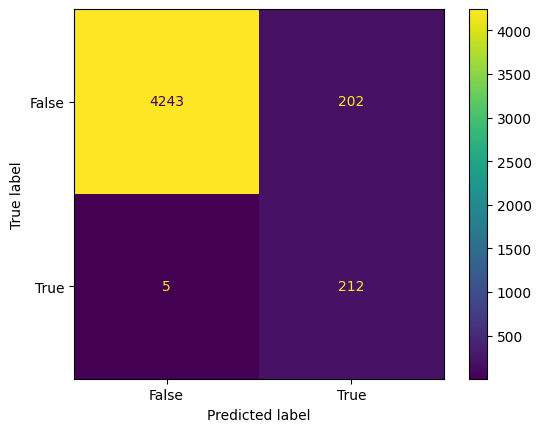

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cv.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cv.best_estimator_, X_train, y_train)

# Instance and Feature Selection 

## CNN

In [3]:
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np
import random
seed = 140421
np.random.seed(140421)
random.seed(seed)

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

folds = train_data[fold_column].unique()
model = Pipeline([
        ('sampling', CondensedNearestNeighbour(random_state=seed)),
        ('nb', GaussianNB())
    ])

cnn = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn.cv_results_))
print(cnn.best_estimator_, cnn.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.348420      0.052373         0.020597        0.003910   
1        0.352142      0.059605         0.017282        0.000491   
2        0.464072      0.103846         0.018521        0.001851   
3        0.286278      0.056951         0.018530        0.001490   
4        0.354071      0.050233         0.017561        0.001187   
..            ...           ...              ...             ...   
70       0.367843      0.062543         0.016956        0.000740   
71       0.436715      0.067949         0.016976        0.000578   
72       0.301537      0.072714         0.019091        0.003495   
73       0.375011      0.072328         0.018232        0.001644   
74       0.496688      0.121227         0.019847        0.001841   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.674556   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.686391   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.622222   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.682635   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.622222   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.622222   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.622222   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.666667   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.622222   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.622222   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.712500        0.675497        0.693333      0.688972     0.015508   
1         0.600000        0.800000        0.712329      0.699680     0.071304   
2         0.629371        0.796460        0.676056      0.681027     0.069778   
3         0.712500        0.709677        0.722222      0.706759     0.014685   
4         0.638298        0.671756        0.676056      0.652083     0.022602   
..             ...             ...             ...           ...          ...   
70        0.638298        0.681818        0.676056      0.654599     0.025076   
71        0.629371        0.681481        0.741935      0.668752     0.048046   
72        0.712500        0.713376        0.722222      0.703691     0.021712   
73        0.638298        0.681818        0.676056      0.654599     0.025076   
74        0.629371        0.681481        0.741935      0.668752     0.048046   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             26            0.919355            0.919355  ...   
1             25            0.935484            0.725806  ...   
2             27            0.677419            0.725806  ...   
3             10            0.919355            0.919355  ...   
4             73            0.677419            0.725806  ...   
..           ...                 ...                 ...  ...   
70            52            0.677419            0.725806  ...   
71            28            0.677419            0.725806  ...   
72            20            0.8

Pipeline(steps=[('sampling',
                 CondensedNearestNeighbour(n_neighbors=1, random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(8.3425e-09)))]) 0.7088264176774657


                 False        True  accuracy    macro avg  weighted avg
precision     0.995140    0.574780  0.964393     0.784960      0.975574
recall        0.967379    0.903226  0.964393     0.935302      0.964393
f1-score      0.981063    0.702509  0.964393     0.841786      0.968097
support    4445.000000  217.000000  0.964393  4662.000000   4662.000000


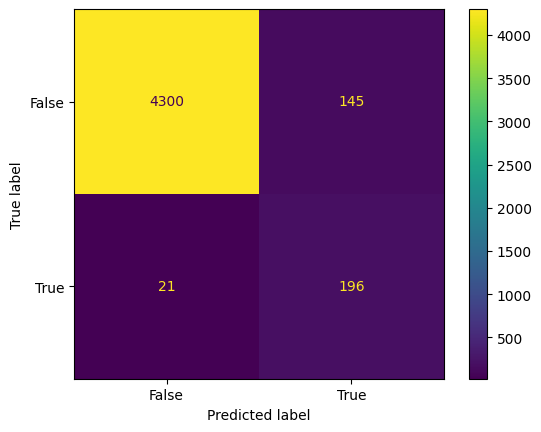

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn.best_estimator_, X_train, y_train)

## SmoteTomek

In [5]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import numpy as np

np.random.seed(140421)


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

folds = train_data[fold_column].unique()
model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('nb', GaussianNB())
    ])

smt = GridSearchCV(
  estimator = model, 
  param_grid={
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

smt.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(smt.cv_results_))
print(smt.best_estimator_, smt.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.324963      0.089748         0.022792        0.006777   
1        0.305821      0.053457         0.021314        0.001586   
2        0.309178      0.043275         0.028179        0.003967   
3        0.326151      0.043008         0.023462        0.002781   
4        0.297223      0.015804         0.020959        0.002169   
5        0.313498      0.047040         0.020886        0.003534   
6        0.283592      0.039190         0.021810        0.002192   
7        0.307758      0.026604         0.020107        0.002041   
8        0.284463      0.052001         0.023153        0.002301   
9        0.298476      0.026574         0.020540        0.002745   
10       0.254918      0.043057         0.020442        0.001202   
11       0.232067      0.039205         0.018903        0.000907   
12       0.271409      0.029409         0.020069        0.001115   
13       0.228064      0.038406         0.021743        0.002997   
14       0.242278      0.054575         0.020514        0.003103   
15       0.218206      0.040553         0.020635        0.000784   
16       0.298434      0.063455         0.020188        0.001693   
17       0.272076      0.034538         0.020600        0.002504   
18       0.273247      0.021082         0.019533        0.000537   
19       0.248824      0.042835         0.018801        0.000528   
20       0.268392      0.021037         0.018221        0.000473   
21       0.242565      0.074087         0.019429        0.002235   
22       0.205255      0.030299         0.019931        0.003705   
23       0.235435      0.050425         0.017805        0.000565   
24       0.246520      0.034773         0.018823        0.000608   

    param_nb__var_smoothing                                         params  \
0              1.000000e-11                   {'nb__var_smoothing': 1e-11}   
1              4.176250e-09             {'nb__var_smoothing': 4.17625e-09}   
2              8.342500e-09              {'nb__var_smoothing': 8.3425e-09}   
3              1.250875e-08  {'nb__var_smoothing': 1.2508750000000001e-08}   
4              1.667500e-08  {'nb__var_smoothing': 1.6675000000000002e-08}   
5              2.084125e-08            {'nb__var_smoothing': 2.084125e-08}   
6              2.500750e-08  {'nb__var_smoothing': 2.5007500000000004e-08}   
7              2.917375e-08  {'nb__var_smoothing': 2.9173750000000003e-08}   
8              3.334000e-08               {'nb__var_smoothing': 3.334e-08}   
9              3.750625e-08            {'nb__var_smoothing': 3.750625e-08}   
10             4.167250e-08             {'nb__var_smoothing': 4.16725e-08}   
11             4.583875e-08            {'nb__var_smoothing': 4.583875e-08}   
12             5.000500e-08  {'nb__var_smoothing': 5.0005000000000003e-08}   
13             5.417125e-08            {'nb__var_smoothing': 5.417125e-08}   
14             5.833750e-08             {'nb__var_smoothing': 5.83375e-08}   
15             6.250375e-08            {'nb__var_smoothing': 6.250375e-08}   
16             6.667000e-08               {'nb__var_smoothing': 6.667e-08}   
17             7.083625e-08   {'nb__var_smoothing': 7.083625000000001e-08}   
18             7.500250e-08             {'nb__var_smoothing': 7.50025e-08}   
19             7.916875e-08            {'nb__var_smoothing': 7.916875e-08}   
20             8.333500e-08              {'nb__var_smoothing': 8.3335e-08}   
21             8.750125e-08            {'nb__var_smoothing': 8.750125e-08}   
22             9.166750e-08             {'nb__var_smoothing': 9.16675e-08}   
23             9.583375e-08            {'nb__var_smoothing': 9.583375e-08}   
24             1.000000e-07                   {'nb__var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.641304        0.663043        0.670330            0.75   
1         0.644809        0.666667        0.662983            0.75

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(1e-11)))]) 0.6811693741041567


                 False        True  accuracy    macro avg  weighted avg
precision     0.998823    0.512077  0.955598     0.755450      0.976167
recall        0.954556    0.976959  0.955598     0.965757      0.955598
f1-score      0.976188    0.671949  0.955598     0.824069      0.962026
support    4445.000000  217.000000  0.955598  4662.000000   4662.000000


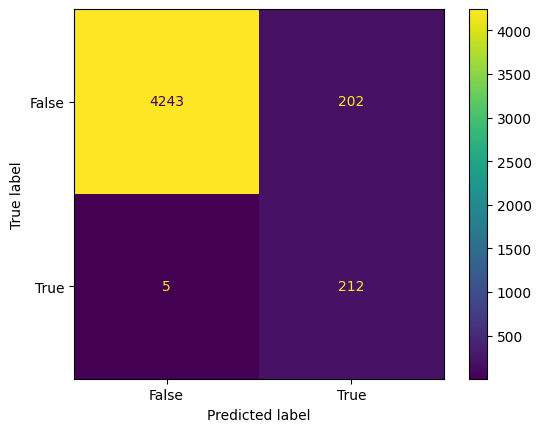

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = smt.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(smt.best_estimator_, X_train, y_train)

## MRMR

In [7]:
MRMR = [ 
  "Towers_mean", 
  "DV_eletric_var",
  "DV_pressure_median",
  "TP2_max",
  "Towers_median",        
  "Reservoirs_max",
  "DV_eletric_min",       
  "Pressure_switch_min", 
  "Motor_current_var",
  "Towers_var",
  "LPS_min",
  "DV_pressure_min",
  "Towers_min",
  "TP2_median", 
  "Oil_level_max",
  "Reservoirs_mean",
  "DV_pressure_mean",
  "Oil_temperature_min",
  "Oil_temperature_var",  
  "DV_eletric_median",
  "Caudal_impulses_max",
  "DV_pressure_var", 
  "LPS_max"              ,
  "H1_max",
  "Motor_current_max",
  "Motor_current_median",
  "COMP_min",
  # "TP2_var",
  # "DV_eletric_mean",      
  # "TP3_var",
  # "Reservoirs_median",
  # "H1_median",
]

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()

mrmr = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(mrmr.cv_results_))
print(mrmr.best_estimator_, mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.004660      0.000293         0.015826        0.000305   
1        0.004873      0.000281         0.017352        0.001026   
2        0.005345      0.000312         0.017712        0.000594   
3        0.005901      0.001173         0.018240        0.002580   
4        0.004748      0.000425         0.016194        0.000737   
5        0.005049      0.000303         0.016541        0.000569   
6        0.004807      0.000453         0.016370        0.000349   
7        0.005108      0.000199         0.016201        0.000652   
8        0.004702      0.000575         0.015736        0.000299   
9        0.004397      0.000309         0.015021        0.000529   
10       0.005340      0.000821         0.016783        0.000704   
11       0.005593      0.000400         0.018250        0.002346   
12       0.008753      0.000563         0.022707        0.004959   
13       0.004418      0.000374         0.014291        0.000604   
14       0.005438      0.000972         0.018414        0.001635   
15       0.005353      0.001295         0.016230        0.001250   
16       0.004495      0.000272         0.014832        0.000666   
17       0.004703      0.000452         0.015885        0.001182   
18       0.006207      0.000638         0.019410        0.000670   
19       0.005555      0.001524         0.016612        0.000242   
20       0.004650      0.000120         0.015419        0.000446   
21       0.004583      0.000342         0.015645        0.000573   
22       0.004545      0.000086         0.015230        0.000906   
23       0.004798      0.000492         0.015839        0.000683   
24       0.004835      0.000362         0.016153        0.000363   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.634409        0.673913        0.677778            0.75   
1         0.641304        0.681319        0.677778            0.75   
2         0.641304        0.685083        0.677778            0.75   
3         0.644809        0.685083        0.677778            0.75   
4         0.644809        0.685083        0.677778            0.

GaussianNB(var_smoothing=np.float64(1.2508750000000001e-08)) 0.6894173484688384


                 False        True  accuracy    macro avg  weighted avg
precision     0.998825    0.523457  0.957529     0.761141      0.976699
recall        0.956580    0.976959  0.957529     0.966769      0.957529
f1-score      0.977247    0.681672  0.957529     0.829459      0.963489
support    4445.000000  217.000000  0.957529  4662.000000   4662.000000


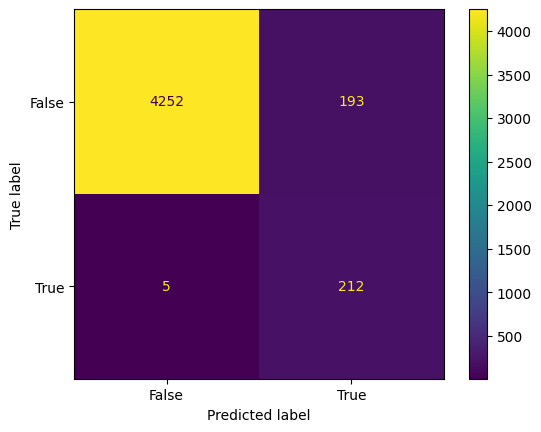

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = mrmr.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(mrmr.best_estimator_, X_train, y_train)

## CHI-Squared

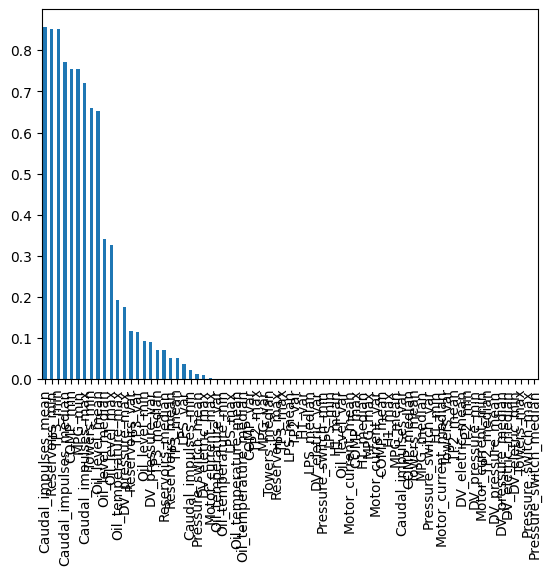

Index(['TP2_mean', 'TP2_max', 'TP2_min', 'TP2_median', 'TP2_var', 'TP3_max',
       'H1_mean', 'H1_max', 'H1_min', 'H1_median', 'H1_var',
       'DV_pressure_mean', 'DV_pressure_min', 'DV_pressure_median',
       'Reservoirs_max', 'Oil_temperature_mean', 'Oil_temperature_min',
       'Oil_temperature_median', 'Oil_temperature_var', 'Motor_current_mean',
       'Motor_current_max', 'Motor_current_min', 'Motor_current_median',
       'Motor_current_var', 'COMP_mean', 'COMP_max', 'COMP_median', 'COMP_var',
       'DV_eletric_mean', 'DV_eletric_max', 'DV_eletric_min',
       'DV_eletric_median', 'DV_eletric_var', 'Towers_mean', 'Towers_median',
       'Towers_var', 'MPG_mean', 'MPG_max', 'MPG_median', 'MPG_var',
       'LPS_mean', 'LPS_max', 'LPS_min', 'LPS_median', 'LPS_var',
       'Pressure_switch_mean', 'Pressure_switch_min', 'Pressure_switch_var',
       'Oil_level_var', 'Caudal_impulses_min', 'Caudal_impulses_var'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.006674      0.000604         0.016613        0.000282   
1        0.007927      0.001216         0.019256        0.002039   
2        0.006768      0.000660         0.015528        0.000533   
3        0.006294      0.000817         0.015924        0.000778   
4        0.007442      0.000604         0.017656        0.001129   
5        0.007413      0.000665         0.016203        0.000895   
6        0.006937      0.000660         0.016196        0.000756   
7        0.007298      0.000885         0.016638        0.000597   
8        0.006088      0.000335         0.016626        0.000669   
9        0.007275      0.000726         0.018032        0.001098   
10       0.007299      0.000677         0.016678        0.000473   
11       0.006408      0.000559         0.016635        0.001109   
12       0.008080      0.000485         0.018876        0.001976   
13       0.007628      0.001467         0.019201        0.004199   
14       0.010625      0.000183         0.026263        0.001994   
15       0.007495      0.002593         0.016520        0.002973   
16       0.006404      0.000161         0.015659        0.000263   
17       0.006779      0.000368         0.016576        0.000532   
18       0.006401      0.000304         0.015719        0.000539   
19       0.006442      0.000478         0.016694        0.000626   
20       0.006092      0.000305         0.015193        0.001211   
21       0.007338      0.001474         0.016853        0.001335   
22       0.009914      0.001375         0.023182        0.003666   
23       0.007522      0.000346         0.018398        0.001053   
24       0.009104      0.000077         0.023048        0.001289   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.648352         0.67033         0.67033            0.75   
1         0.648352         0.67033         0.67033            0.75   
2         0.648352         0.67033         0.67033            0.75   
3         0.648352         0.67033         0.67033            0.75   
4         0.648352         0.67033         0.67033            0.

GaussianNB(var_smoothing=np.float64(1e-11)) 0.6847527472527473


In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 
chi_scores = chi2(x_train, y_train)
p_values = pd.Series(chi_scores[1],index = X_train.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()
plt.show()

indexes = chi_scores[1] <= 0.05
columns = X_train.columns
print(columns[indexes])

X_train = X_train.loc[:, indexes]

chi = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

chi.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(chi.cv_results_))
print(chi.best_estimator_, chi.best_score_)

                 False        True  accuracy    macro avg  weighted avg
precision     0.998590    0.518428  0.956671     0.758509      0.976240
recall        0.955906    0.972350  0.956671     0.964128      0.956671
f1-score      0.976782    0.676282  0.956671     0.826532      0.962794
support    4445.000000  217.000000  0.956671  4662.000000   4662.000000


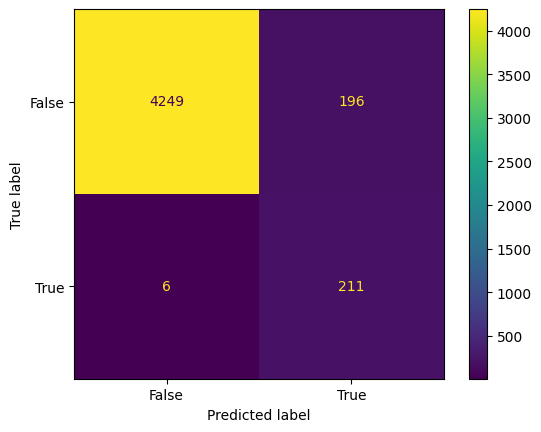

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = chi.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(chi.best_estimator_, X_train, y_train)

## CNN + ChiSquared

In [11]:
import matplotlib.pyplot as plt
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
# feature_columns = MRMR
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 

chi_scores = chi2(x_train, y_train)

indexes = chi_scores[1] <= 0.05
columns = X_train.columns
print(columns[indexes])


X_train = X_train.loc[:, indexes]

model = Pipeline([
        ('sampling', CondensedNearestNeighbour()),
        ('nb', GaussianNB())
    ])

cnn_chi = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn_chi.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn_chi.cv_results_))
print(cnn_chi.best_estimator_, cnn_chi.best_score_)

Index(['TP2_mean', 'TP2_max', 'TP2_min', 'TP2_median', 'TP2_var', 'TP3_max',
       'H1_mean', 'H1_max', 'H1_min', 'H1_median', 'H1_var',
       'DV_pressure_mean', 'DV_pressure_min', 'DV_pressure_median',
       'Reservoirs_max', 'Oil_temperature_mean', 'Oil_temperature_min',
       'Oil_temperature_median', 'Oil_temperature_var', 'Motor_current_mean',
       'Motor_current_max', 'Motor_current_min', 'Motor_current_median',
       'Motor_current_var', 'COMP_mean', 'COMP_max', 'COMP_median', 'COMP_var',
       'DV_eletric_mean', 'DV_eletric_max', 'DV_eletric_min',
       'DV_eletric_median', 'DV_eletric_var', 'Towers_mean', 'Towers_median',
       'Towers_var', 'MPG_mean', 'MPG_max', 'MPG_median', 'MPG_var',
       'LPS_mean', 'LPS_max', 'LPS_min', 'LPS_median', 'LPS_var',
       'Pressure_switch_mean', 'Pressure_switch_min', 'Pressure_switch_var',
       'Oil_level_var', 'Caudal_impulses_min', 'Caudal_impulses_var'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.253128      0.016694         0.018758        0.001835   
1        0.347351      0.049210         0.022087        0.004886   
2        0.372819      0.046186         0.017977        0.001547   
3        0.249864      0.036692         0.018185        0.002449   
4        0.319672      0.043041         0.017927        0.000337   
..            ...           ...              ...             ...   
70       0.349173      0.040414         0.018730        0.000966   
71       0.370879      0.030216         0.019230        0.002429   
72       0.249700      0.030827         0.020008        0.003748   
73       0.324490      0.052403         0.017083        0.000690   
74       0.412763      0.063754         0.019423        0.001423   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.622222   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.622222   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.730435   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.622222   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.622222   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.622222   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.622222   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.622222   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.622222   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.622222   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.652174        0.691358        0.693333      0.664772     0.029546   
1         0.775862        0.800000        0.800000      0.749521     0.074154   
2         0.765217        0.800000        0.800000      0.773913     0.028840   
3         0.662420        0.674556        0.693333      0.663133     0.026061   
4         0.737705        0.676923        0.721311      0.689540     0.044778   
..             ...             ...             ...           ...          ...   
70        0.652174        0.671756        0.741935      0.672022     0.044051   
71        0.775862        0.800000        0.741935      0.735005     0.068304   
72        0.686391        0.682353        0.693333      0.671075     0.028477   
73        0.652174        0.671756        0.721311      0.666866     0.036046   
74        0.775862        0.800000        0.821429      0.754878     0.078267   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             72            0.677419            0.725806  ...   
1             19            0.677419            0.725806  ...   
2             11            0.677419            0.709677  ...   
3             73            0.677419            0.838710  ...   
4             27            0.677419            0.725806  ...   
..           ...                 ...                 ...  ...   
70            34            0.677419            0.725806  ...   
71            21            0.677419            0.725806  ...   
72            35            0.6

Pipeline(steps=[('sampling', CondensedNearestNeighbour(n_neighbors=10)),
                ('nb', GaussianNB(var_smoothing=np.float64(2.084125e-08)))]) 0.7819313557506959


                 False        True  accuracy    macro avg  weighted avg
precision     0.985724    0.618474  0.966109     0.802099      0.968630
recall        0.978628    0.709677  0.966109     0.844153      0.966109
f1-score      0.982163    0.660944  0.966109     0.821554      0.967211
support    4445.000000  217.000000  0.966109  4662.000000   4662.000000


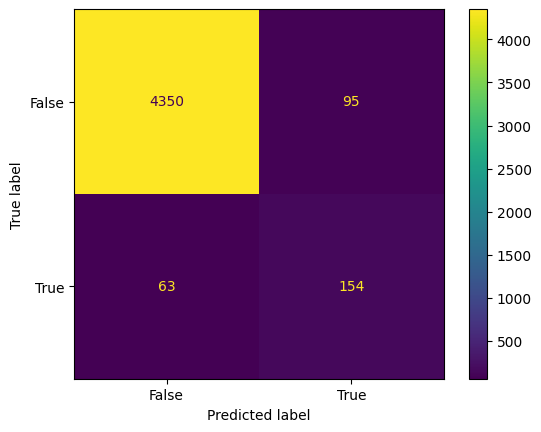

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn_chi.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_chi.best_estimator_, X_train, y_train)

# CNN + MRMR

In [13]:
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR
# feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

model = Pipeline([
        ('sampling', CondensedNearestNeighbour()),
        ('nb', GaussianNB())
    ])

cnn_mrmr = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn_mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn_mrmr.cv_results_))
print(cnn_mrmr.best_estimator_, cnn_mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.415846      0.131129         0.021519        0.002091   
1        0.319156      0.033604         0.022979        0.006085   
2        0.392743      0.079339         0.020732        0.003970   
3        0.341279      0.065213         0.019953        0.001109   
4        0.330813      0.032370         0.020382        0.001810   
..            ...           ...              ...             ...   
70       0.281640      0.034971         0.016977        0.001018   
71       0.334523      0.063019         0.018233        0.002780   
72       0.303227      0.055939         0.017285        0.001545   
73       0.290730      0.020275         0.018063        0.000750   
74       0.346785      0.051755         0.018611        0.002768   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.686391   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.686391   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.686391   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.686391   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.670659   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.562092   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.716667   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.686391   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.552632   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.716667   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.712500        0.401826        0.684211      0.621232     0.127162   
1         0.695122        0.800000        0.363636      0.636287     0.163640   
2         0.720497        0.774775        0.746667      0.732082     0.032624   
3         0.712500        0.415929        0.684211      0.624758     0.121080   
4         0.712500        0.800000        0.363636      0.636699     0.164415   
..             ...             ...             ...           ...          ...   
70        0.716981        0.800000        0.363636      0.610677     0.166233   
71        0.640000        0.796460        0.722222      0.718837     0.055355   
72        0.712500        0.459016        0.684211      0.635529     0.102516   
73        0.716981        0.800000        0.363636      0.608312     0.166973   
74        0.621622        0.789474        0.712329      0.710023     0.059533   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             59            0.935484            0.919355  ...   
1             38            0.935484            0.919355  ...   
2              1            0.935484            0.935484  ...   
3             54            0.935484            0.919355  ...   
4             37            0.903226            0.919355  ...   
..           ...                 ...                 ...  ...   
70            68            0.693548            0.919355  ...   
71             4            0.693548            0.774194  ...   
72            39            0.9

Pipeline(steps=[('sampling', CondensedNearestNeighbour(n_neighbors=10)),
                ('nb', GaussianNB(var_smoothing=np.float64(1e-11)))]) 0.7320822170989395


                 False        True  accuracy    macro avg  weighted avg
precision     0.995829    0.575145  0.964607     0.785487      0.976248
recall        0.966929    0.917051  0.964607     0.941990      0.964607
f1-score      0.981167    0.706927  0.964607     0.844047      0.968402
support    4445.000000  217.000000  0.964607  4662.000000   4662.000000


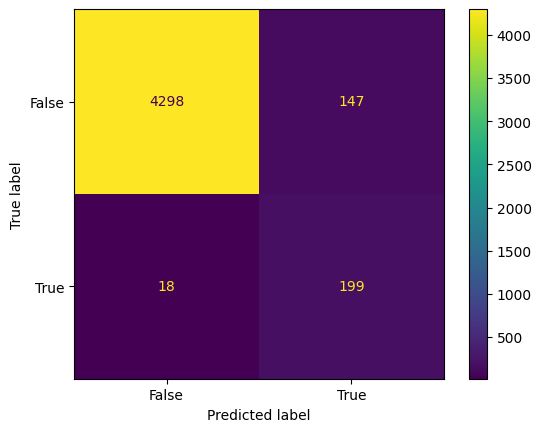

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn_mrmr.best_estimator_.predict(X_train[MRMR])
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_mrmr.best_estimator_, X_train[MRMR], y_train)

## SMOTELinks + MRMR

In [15]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR
# feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('nb', GaussianNB())
    ])

smt_mrmr = GridSearchCV(
  estimator = model, 
  param_grid={
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

smt_mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(smt_mrmr.cv_results_))
print(smt_mrmr.best_estimator_, smt_mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.169885      0.042422         0.019126        0.001674   
1        0.211317      0.032928         0.023664        0.006799   
2        0.144175      0.028134         0.018417        0.000811   
3        0.172690      0.031735         0.017631        0.000964   
4        0.173559      0.025817         0.018828        0.001428   
5        0.161231      0.011462         0.018724        0.001926   
6        0.154059      0.038692         0.018437        0.001765   
7        0.152544      0.011939         0.019122        0.001053   
8        0.158585      0.049997         0.018957        0.001376   
9        0.165529      0.021092         0.018519        0.001446   
10       0.176380      0.040918         0.020484        0.001843   
11       0.170022      0.025063         0.018532        0.001409   
12       0.163761      0.032187         0.018680        0.002788   
13       0.161310      0.019952         0.016540        0.000521   
14       0.165040      0.028074         0.017413        0.000628   
15       0.172822      0.041119         0.019951        0.002950   
16       0.175394      0.034716         0.017162        0.000316   
17       0.165018      0.044793         0.020460        0.004608   
18       0.155096      0.048124         0.020752        0.004538   
19       0.166916      0.018194         0.018461        0.001301   
20       0.134557      0.025772         0.017996        0.000420   
21       0.146107      0.015424         0.018559        0.000625   
22       0.163071      0.042142         0.018104        0.000111   
23       0.177239      0.024975         0.018823        0.001143   
24       0.139912      0.041570         0.019069        0.001449   

    param_nb__var_smoothing                                         params  \
0              1.000000e-11                   {'nb__var_smoothing': 1e-11}   
1              4.176250e-09             {'nb__var_smoothing': 4.17625e-09}   
2              8.342500e-09              {'nb__var_smoothing': 8.3425e-09}   
3              1.250875e-08  {'nb__var_smoothing': 1.2508750000000001e-08}   
4              1.667500e-08  {'nb__var_smoothing': 1.6675000000000002e-08}   
5              2.084125e-08            {'nb__var_smoothing': 2.084125e-08}   
6              2.500750e-08  {'nb__var_smoothing': 2.5007500000000004e-08}   
7              2.917375e-08  {'nb__var_smoothing': 2.9173750000000003e-08}   
8              3.334000e-08               {'nb__var_smoothing': 3.334e-08}   
9              3.750625e-08            {'nb__var_smoothing': 3.750625e-08}   
10             4.167250e-08             {'nb__var_smoothing': 4.16725e-08}   
11             4.583875e-08            {'nb__var_smoothing': 4.583875e-08}   
12             5.000500e-08  {'nb__var_smoothing': 5.0005000000000003e-08}   
13             5.417125e-08            {'nb__var_smoothing': 5.417125e-08}   
14             5.833750e-08             {'nb__var_smoothing': 5.83375e-08}   
15             6.250375e-08            {'nb__var_smoothing': 6.250375e-08}   
16             6.667000e-08               {'nb__var_smoothing': 6.667e-08}   
17             7.083625e-08   {'nb__var_smoothing': 7.083625000000001e-08}   
18             7.500250e-08             {'nb__var_smoothing': 7.50025e-08}   
19             7.916875e-08            {'nb__var_smoothing': 7.916875e-08}   
20             8.333500e-08              {'nb__var_smoothing': 8.3335e-08}   
21             8.750125e-08            {'nb__var_smoothing': 8.750125e-08}   
22             9.166750e-08             {'nb__var_smoothing': 9.16675e-08}   
23             9.583375e-08            {'nb__var_smoothing': 9.583375e-08}   
24             1.000000e-07                   {'nb__var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.637838        0.694118        0.722892            0.75   
1         0.644809        0.694118        0.722892            0.75

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(4.16725e-08)))]) 0.7047357287453356


                 False        True  accuracy    macro avg  weighted avg
precision     0.998594    0.532828   0.95903     0.765711      0.976914
recall        0.958380    0.972350   0.95903     0.965365      0.959030
f1-score      0.978074    0.688418   0.95903     0.833246      0.964591
support    4445.000000  217.000000   0.95903  4662.000000   4662.000000


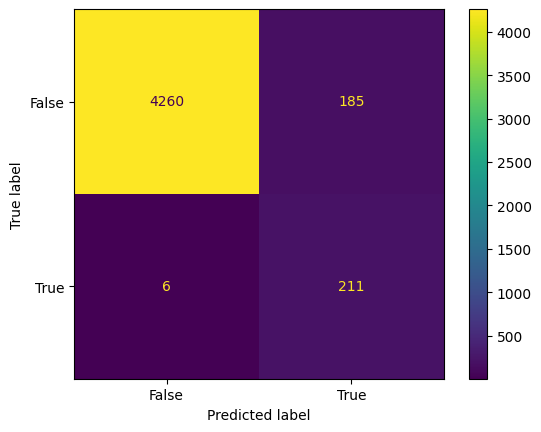

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = smt_mrmr.best_estimator_.predict(X_train[MRMR])
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(smt_mrmr.best_estimator_, X_train[MRMR], y_train)

## SMOTETomek + CHI

In [33]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
# feature_columns = MRMR
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 

chi_scores = chi2(x_train, y_train)

indexes = chi_scores[1] <= 0.05
columns = X_train.columns
print(columns[indexes])


X_train = X_train.loc[:, indexes]

model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('nb', GaussianNB())
    ])

smt_chi = GridSearchCV(
  estimator = model, 
  param_grid={
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

smt_chi.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(smt_chi.cv_results_))
print(smt_chi.best_estimator_, smt_chi.best_score_)

Index(['TP2_mean', 'TP2_max', 'TP2_min', 'TP2_median', 'TP2_var', 'TP3_max',
       'H1_mean', 'H1_max', 'H1_min', 'H1_median', 'H1_var',
       'DV_pressure_mean', 'DV_pressure_min', 'DV_pressure_median',
       'Reservoirs_max', 'Oil_temperature_mean', 'Oil_temperature_min',
       'Oil_temperature_median', 'Oil_temperature_var', 'Motor_current_mean',
       'Motor_current_max', 'Motor_current_min', 'Motor_current_median',
       'Motor_current_var', 'COMP_mean', 'COMP_max', 'COMP_median', 'COMP_var',
       'DV_eletric_mean', 'DV_eletric_max', 'DV_eletric_min',
       'DV_eletric_median', 'DV_eletric_var', 'Towers_mean', 'Towers_median',
       'Towers_var', 'MPG_mean', 'MPG_max', 'MPG_median', 'MPG_var',
       'LPS_mean', 'LPS_max', 'LPS_min', 'LPS_median', 'LPS_var',
       'Pressure_switch_mean', 'Pressure_switch_min', 'Pressure_switch_var',
       'Oil_level_var', 'Caudal_impulses_min', 'Caudal_impulses_var'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.214877      0.042167         0.023512        0.004989   
1        0.253900      0.043210         0.024926        0.004262   
2        0.206569      0.044807         0.021511        0.004315   
3        0.190513      0.045829         0.019234        0.002455   
4        0.219088      0.055277         0.026741        0.004668   
5        0.277648      0.092487         0.023268        0.002468   
6        0.197776      0.022474         0.018784        0.000840   
7        0.219999      0.057962         0.023118        0.005220   
8        0.287552      0.074969         0.027359        0.004465   
9        0.240199      0.018637         0.019961        0.002484   
10       0.217980      0.050880         0.018542        0.000203   
11       0.190324      0.045460         0.018949        0.001316   
12       0.191651      0.050190         0.018525        0.000865   
13       0.225514      0.048072         0.019540        0.001921   
14       0.203241      0.041837         0.019178        0.001156   
15       0.211335      0.035705         0.018273        0.003254   
16       0.209864      0.029113         0.017990        0.001208   
17       0.216926      0.027531         0.018897        0.000420   
18       0.176106      0.044232         0.018768        0.000391   
19       0.203146      0.039890         0.018704        0.001334   
20       0.194754      0.024242         0.018045        0.000476   
21       0.192605      0.046338         0.020406        0.003734   
22       0.207324      0.034692         0.018177        0.001288   
23       0.219481      0.027963         0.017605        0.000570   
24       0.210653      0.005644         0.020610        0.003460   

    param_nb__var_smoothing                                         params  \
0              1.000000e-11                   {'nb__var_smoothing': 1e-11}   
1              4.176250e-09             {'nb__var_smoothing': 4.17625e-09}   
2              8.342500e-09              {'nb__var_smoothing': 8.3425e-09}   
3              1.250875e-08  {'nb__var_smoothing': 1.2508750000000001e-08}   
4              1.667500e-08  {'nb__var_smoothing': 1.6675000000000002e-08}   
5              2.084125e-08            {'nb__var_smoothing': 2.084125e-08}   
6              2.500750e-08  {'nb__var_smoothing': 2.5007500000000004e-08}   
7              2.917375e-08  {'nb__var_smoothing': 2.9173750000000003e-08}   
8              3.334000e-08               {'nb__var_smoothing': 3.334e-08}   
9              3.750625e-08            {'nb__var_smoothing': 3.750625e-08}   
10             4.167250e-08             {'nb__var_smoothing': 4.16725e-08}   
11             4.583875e-08            {'nb__var_smoothing': 4.583875e-08}   
12             5.000500e-08  {'nb__var_smoothing': 5.0005000000000003e-08}   
13             5.417125e-08            {'nb__var_smoothing': 5.417125e-08}   
14             5.833750e-08             {'nb__var_smoothing': 5.83375e-08}   
15             6.250375e-08            {'nb__var_smoothing': 6.250375e-08}   
16             6.667000e-08               {'nb__var_smoothing': 6.667e-08}   
17             7.083625e-08   {'nb__var_smoothing': 7.083625000000001e-08}   
18             7.500250e-08             {'nb__var_smoothing': 7.50025e-08}   
19             7.916875e-08            {'nb__var_smoothing': 7.916875e-08}   
20             8.333500e-08              {'nb__var_smoothing': 8.3335e-08}   
21             8.750125e-08            {'nb__var_smoothing': 8.750125e-08}   
22             9.166750e-08             {'nb__var_smoothing': 9.16675e-08}   
23             9.583375e-08            {'nb__var_smoothing': 9.583375e-08}   
24             1.000000e-07                   {'nb__var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.648352         0.67033        0.674033            0.75   
1         0.648352         0.67033        0.674033            0.75

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('nb',
                 GaussianNB(var_smoothing=np.float64(5.0005000000000003e-08)))]) 0.6865741302895999


                 False        True  accuracy    macro avg  weighted avg
precision     0.998591    0.520988    0.9571     0.759789       0.97636
recall        0.956355    0.972350    0.9571     0.964353       0.95710
f1-score      0.977017    0.678457    0.9571     0.827737       0.96312
support    4445.000000  217.000000    0.9571  4662.000000    4662.00000


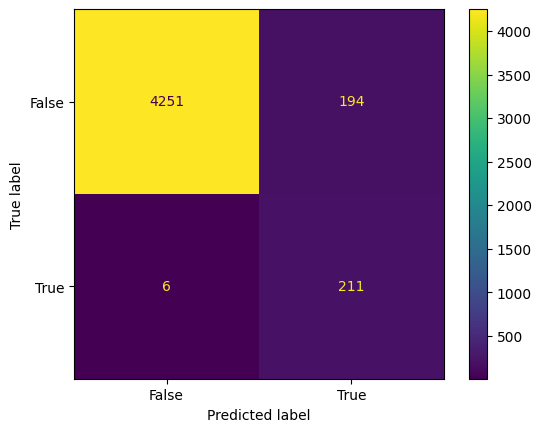

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = smt_chi.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(smt_chi.best_estimator_, X_train, y_train)

# Entrenar el modelo de Stacking

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

svc = Pipeline(
  [ 
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=seed))
  ]
)

seed = 140421
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', svc),
    ('nb', GaussianNB())
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)
# Hacemos un GridSearch
scv = GridSearchCV(
  estimator = stack, 
  param_grid = {
    # Decision Tree 
    'dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'svc__model__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv.cv_results_))
print(scv.best_estimator_, scv.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.029384      0.075257         0.063585        0.008391   
1        0.876530      0.049506         0.050633        0.001141   
2        0.819957      0.057528         0.042451        0.003345   
3        0.949383      0.069883         0.063387        0.010948   
4        0.885983      0.074099         0.048107        0.005098   
5        0.809606      0.052710         0.049627        0.009651   
6        1.057551      0.146898         0.067492        0.001856   
7        0.999790      0.057827         0.052468        0.007171   
8        0.869820      0.043044         0.044331        0.003390   
9        1.082935      0.063608         0.077170        0.013234   
10       0.901922      0.062199         0.048407        0.005056   
11       0.835573      0.051594         0.049504        0.014002   
12       0.767795      0.053650         0.059851        0.006113   
13       0.637900      0.062350         0.047931        0.004696   
14       0.588699      0.056356         0.048035        0.011439   
15       0.764417      0.092086         0.061807        0.006909   
16       0.697810      0.072409         0.050480        0.006324   
17       0.635877      0.062015         0.043254        0.002509   
18       0.871735      0.096346         0.068258        0.010816   
19       0.740091      0.082323         0.061682        0.019120   
20       0.694313      0.048099         0.046238        0.004805   
21       0.851512      0.096857         0.066950        0.012469   
22       0.751256      0.067462         0.055132        0.005030   
23       0.707144      0.035699         0.050382        0.006783   

   param_dt__criterion param_dt__max_depth param_final_estimator__penalty  \
0                 gini                None                           None   
1                 gini                None                           None   
2                 gini                None                           None   
3                 gini                None                             l2   
4                 gini                None                             l2   
5                 gini                None                             l2   
6                 gini                  10                           None   
7                 gini                  10                           None   
8                 gini                  10                           None   
9                 gini                  10                             l2   
10                gini                  10                             l2   
11                gini                  10                             l2   
12             entropy                None                           None   
13             entropy                None                           None   
14             entropy                None                           None   
15             entropy                None                             l2   
16             entropy                None                             l2   
17             entropy                None                             l2   
18             entropy                  10                           None   
19             entropy                  10                           None   
20             entropy                  10                           None   
21             entropy                  10                             l2   
22             entropy                  10                             l2   
23             entropy                  10                             l2   

    param_svc__model__C                                             params  \
0                   0.1  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
1                   1.0  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
2                  10.0  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
3                   0.1  {'dt__criterion': 'gini', 'dt__max_depth

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=140421)),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 SVC(C=10,
                                                     random_state=140421))])),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression()) 0.9376960638022266


                 False        True  accuracy    macro avg  weighted avg
precision     0.999550    0.995370  0.999356     0.997460      0.999356
recall        0.999775    0.990783  0.999356     0.995279      0.999356
f1-score      0.999663    0.993072  0.999356     0.996367      0.999356
support    4445.000000  217.000000  0.999356  4662.000000   4662.000000


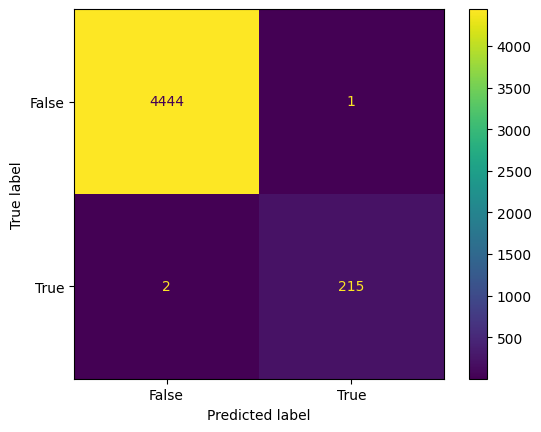

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv.best_estimator_, X_train, y_train)

In [19]:
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv.best_estimator_.final_estimator_.coef_.flatten()  # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         1.378046            23.431104
1        svc         3.089354            52.528692
2         nb         1.413869            24.040205


## Stacking + SMOTETomek

In [20]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek 
from imblearn.pipeline import Pipeline

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

seed = 140421

svc = Pipeline(
  [ 
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=seed))
  ]
)
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', svc),
    ('nb', GaussianNB())
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)

model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('stack', stack)
    ])
# Hacemos un GridSearch
scv_smt = GridSearchCV(
  estimator = model, 
  param_grid = {
    # Decision Tree 
    'stack__dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'stack__dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'stack__svc__model__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'stack__final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv_smt.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv_smt.cv_results_))
print(scv_smt.best_estimator_, scv_smt.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.546174      0.237060         0.115903        0.019792   
1        2.758925      0.317536         0.075347        0.008206   
2        2.484163      0.230897         0.063492        0.009807   
3        3.391584      0.445704         0.108633        0.016309   
4        2.871688      0.298489         0.076061        0.008309   
5        2.443765      0.228076         0.058857        0.005386   
6        3.232665      0.413791         0.120902        0.031629   
7        2.473093      0.253758         0.076750        0.008358   
8        2.181604      0.136715         0.069200        0.020625   
9        3.030256      0.342577         0.108242        0.015801   
10       2.425293      0.304938         0.076205        0.008079   
11       2.116090      0.150579         0.071280        0.020584   
12       2.907281      0.375696         0.113150        0.018656   
13       2.132330      0.247403         0.074484        0.008173   
14       1.903778      0.214888         0.058679        0.004936   
15       2.838280      0.358282         0.119007        0.027305   
16       2.235560      0.308125         0.077438        0.008404   
17       1.868150      0.185381         0.058329        0.004657   
18       2.834854      0.446258         0.113203        0.018045   
19       2.181981      0.298712         0.076534        0.008174   
20       1.935354      0.173980         0.058253        0.004919   
21       2.889890      0.304237         0.109004        0.016269   
22       2.281290      0.277022         0.091792        0.033842   
23       1.882940      0.172237         0.058330        0.003539   

   param_stack__dt__criterion param_stack__dt__max_depth  \
0                        gini                       None   
1                        gini                       None   
2                        gini                       None   
3                        gini                       None   
4                        gini                       None   
5                        gini                       None   
6                        gini                         10   
7                        gini                         10   
8                        gini                         10   
9                        gini                         10   
10                       gini                         10   
11                       gini                         10   
12                    entropy                       None   
13                    entropy                       None   
14                    entropy                       None   
15                    entropy                       None   
16                    entropy                       None   
17                    entropy                       None   
18                    entropy                         10   
19                    entropy                         10   
20                    entropy                         10   
21                    entropy                         10   
22                    entropy                         10   
23                    entropy                         10   

   param_stack__final_estimator__penalty  param_stack__svc__model__C  \
0                                   None                         0.1   
1                                   None                         1.0   
2                                   None                        10.0   
3                                     l2                         0.1   
4                                     l2                         1.0   
5                                     l2                        10.0   
6                                   None                         0.1   
7                                   None                         1.0   
8                                   None                        10.0   
9                                     l2                         0.1   
10        

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('stack',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(random_state=140421)),
                                                ('svc',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler()),
                                                                 ('model',
                                                                  SVC(C=10,
                                                                      random_state=140421))])),
                                                ('nb', GaussianNB())],
                                    final_estimator=LogisticRegression(penalty=None)))]) 0.9309337108525814


                 False        True  accuracy    macro avg  weighted avg
precision     1.000000    0.995413  0.999785     0.997706      0.999786
recall        0.999775    1.000000  0.999785     0.999888      0.999785
f1-score      0.999888    0.997701  0.999785     0.998794      0.999786
support    4445.000000  217.000000  0.999785  4662.000000   4662.000000


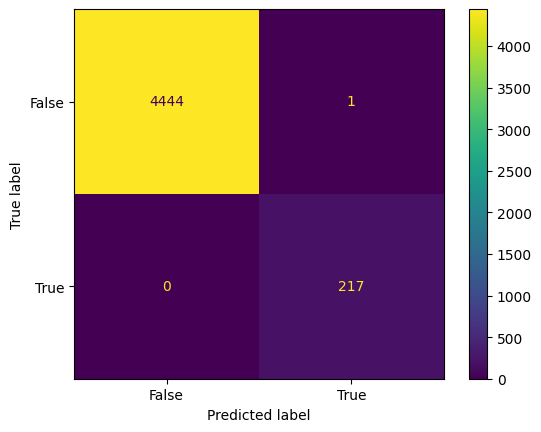

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv_smt.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_smt.best_estimator_, X_train, y_train)

In [22]:
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv_smt.best_estimator_.named_steps["stack"].final_estimator_.coef_.flatten() # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         5.273309            51.224636
1        svc         4.299897            41.768965
2         nb         0.721272             7.006398


## Stacking + CNN

In [23]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

seed = 140421

svc = Pipeline(
  [ 
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=seed))
  ]
)
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', svc),
    ('nb', GaussianNB())
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)

model = Pipeline([
        ('sampling', CondensedNearestNeighbour(n_neighbors=10)),
        ('stack', stack)
    ])
# Hacemos un GridSearch
scv_cnn = GridSearchCV(
  estimator = model, 
  param_grid = {
    # Decision Tree 
    'stack__dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'stack__dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'stack__svc__model__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'stack__final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv_cnn.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv_cnn.cv_results_))
print(scv_cnn.best_estimator_, scv_cnn.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.774321      0.120265         0.052879        0.003025   
1        0.749281      0.074133         0.051191        0.004283   
2        0.725748      0.069834         0.048522        0.002933   
3        0.753130      0.063278         0.052496        0.003540   
4        0.752379      0.078411         0.051068        0.003489   
5        0.735220      0.070098         0.048701        0.003203   
6        0.762785      0.075335         0.052855        0.004092   
7        0.788120      0.072096         0.051233        0.003631   
8        0.749144      0.090036         0.049248        0.003474   
9        0.716092      0.069341         0.052289        0.003723   
10       0.756224      0.067033         0.057348        0.007472   
11       0.792186      0.086621         0.063728        0.017504   
12       0.800324      0.105757         0.055137        0.003542   
13       0.797930      0.100016         0.056140        0.005825   
14       0.722229      0.059826         0.049075        0.002840   
15       0.722165      0.090291         0.068605        0.025065   
16       0.716092      0.052875         0.050819        0.003763   
17       0.741507      0.091425         0.047571        0.002007   
18       0.763487      0.076969         0.056004        0.005017   
19       0.779896      0.119247         0.051325        0.004504   
20       0.723151      0.048559         0.048625        0.002303   
21       0.749825      0.105541         0.059244        0.008961   
22       0.741121      0.071904         0.061674        0.017481   
23       0.731583      0.072053         0.048505        0.002195   

   param_stack__dt__criterion param_stack__dt__max_depth  \
0                        gini                       None   
1                        gini                       None   
2                        gini                       None   
3                        gini                       None   
4                        gini                       None   
5                        gini                       None   
6                        gini                         10   
7                        gini                         10   
8                        gini                         10   
9                        gini                         10   
10                       gini                         10   
11                       gini                         10   
12                    entropy                       None   
13                    entropy                       None   
14                    entropy                       None   
15                    entropy                       None   
16                    entropy                       None   
17                    entropy                       None   
18                    entropy                         10   
19                    entropy                         10   
20                    entropy                         10   
21                    entropy                         10   
22                    entropy                         10   
23                    entropy                         10   

   param_stack__final_estimator__penalty  param_stack__svc__model__C  \
0                                   None                         0.1   
1                                   None                         1.0   
2                                   None                        10.0   
3                                     l2                         0.1   
4                                     l2                         1.0   
5                                     l2                        10.0   
6                                   None                         0.1   
7                                   None                         1.0   
8                                   None                        10.0   
9                                     l2                         0.1   
10        

Pipeline(steps=[('sampling', CondensedNearestNeighbour(n_neighbors=10)),
                ('stack',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(max_depth=10,
                                                                        random_state=140421)),
                                                ('svc',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler()),
                                                                 ('model',
                                                                  SVC(C=10,
                                                                      random_state=140421))])),
                                                ('nb', GaussianNB())],
                                    final_estimator=LogisticRegression(penalty=None)))]) 0.8726279810565722


                 False        True  accuracy    macro avg  weighted avg
precision     1.000000    0.871486  0.993136     0.935743      0.994018
recall        0.992801    1.000000  0.993136     0.996400      0.993136
f1-score      0.996387    0.931330  0.993136     0.963859      0.993359
support    4445.000000  217.000000  0.993136  4662.000000   4662.000000


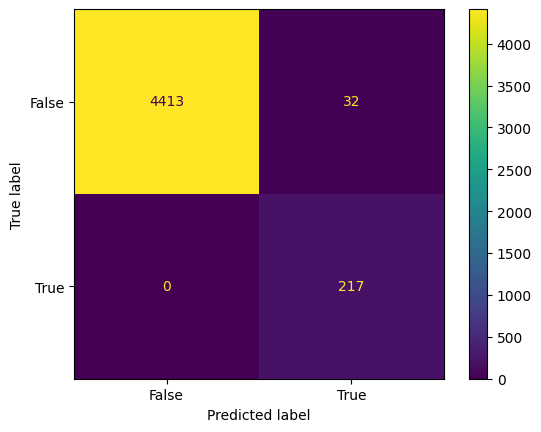

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv_cnn.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_cnn.best_estimator_, X_train, y_train)

In [25]:
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv_cnn.best_estimator_.named_steps["stack"].final_estimator_.coef_.flatten() # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         2.379078            55.305430
1        svc         1.293539            30.070343
2         nb         0.629092            14.624227


## Stacking: Best Config For Each model

In [26]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]
folds = train_data[fold_column].unique()

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

seed = 140421
class ChiSquareExtractor(object):
    def transform(self, X):
        cols = X.loc[:, self.indexes] 
        return cols

    def fit(self, X, y):
      x_train = MinMaxScaler().fit_transform(X) 
      chi_scores = chi2(x_train, y)
      self.indexes = chi_scores[1] <= 0.05
      return self

nb = Pipeline([
        ('sampling', CondensedNearestNeighbour(n_neighbors=10)),
        ('chi', ChiSquareExtractor()),
        ('nb', GaussianNB()),
    ])

svc = Pipeline(
  [ 
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=seed))
  ]
)
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', svc),
    ('nb', nb)
    
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)

model = Pipeline([
        ('stack', stack)
    ])
# Hacemos un GridSearch
scv_edt = GridSearchCV(
  estimator = model, 
  param_grid = {
    # Decision Tree 
    'stack__dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'stack__dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'stack__svc__model__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'stack__final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv_edt.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv_edt.cv_results_))
print(scv_edt.best_estimator_, scv_edt.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.119066      0.302180         0.076801        0.005695   
1        2.955370      0.397407         0.065744        0.005956   
2        2.966297      0.353262         0.077676        0.029465   
3        3.027893      0.342439         0.075864        0.005805   
4        3.097932      0.277189         0.074596        0.012321   
5        3.064603      0.408757         0.059637        0.003747   
6        3.350926      0.586878         0.079566        0.004637   
7        3.279785      0.321124         0.071071        0.011306   
8        3.415420      0.589007         0.087288        0.034854   
9        3.184269      0.285924         0.077663        0.007808   
10       3.037895      0.305508         0.070736        0.011110   
11       2.981647      0.358114         0.059043        0.004102   
12       2.812393      0.371206         0.079469        0.009174   
13       2.796414      0.342537         0.067390        0.007624   
14       2.828562      0.322721         0.059814        0.003390   
15       2.865407      0.366071         0.075945        0.005951   
16       2.949830      0.504271         0.083039        0.016890   
17       2.974151      0.295920         0.065001        0.009169   
18       2.945468      0.380548         0.076352        0.006638   
19       3.300809      0.457905         0.074420        0.009777   
20       3.229388      0.428639         0.063736        0.003025   
21       3.340259      0.466906         0.110814        0.020491   
22       3.169225      0.331778         0.070782        0.005440   
23       3.095068      0.376154         0.092683        0.033392   

   param_stack__dt__criterion param_stack__dt__max_depth  \
0                        gini                       None   
1                        gini                       None   
2                        gini                       None   
3                        gini                       None   
4                        gini                       None   
5                        gini                       None   
6                        gini                         10   
7                        gini                         10   
8                        gini                         10   
9                        gini                         10   
10                       gini                         10   
11                       gini                         10   
12                    entropy                       None   
13                    entropy                       None   
14                    entropy                       None   
15                    entropy                       None   
16                    entropy                       None   
17                    entropy                       None   
18                    entropy                         10   
19                    entropy                         10   
20                    entropy                         10   
21                    entropy                         10   
22                    entropy                         10   
23                    entropy                         10   

   param_stack__final_estimator__penalty  param_stack__svc__model__C  \
0                                   None                         0.1   
1                                   None                         1.0   
2                                   None                        10.0   
3                                     l2                         0.1   
4                                     l2                         1.0   
5                                     l2                        10.0   
6                                   None                         0.1   
7                                   None                         1.0   
8                                   None                        10.0   
9                                     l2                         0.1   
10        

Pipeline(steps=[('stack',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(criterion='entropy',
                                                                        random_state=140421)),
                                                ('svc',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler()),
                                                                 ('model',
                                                                  SVC(C=10,
                                                                      random_state=140421))])),
                                                ('nb',
                                                 Pipeline(steps=[('sampling',
                                                                  CondensedNearestNeighbour(n_neighbors=10)),
                        

                 False        True  accuracy    macro avg  weighted avg
precision     0.999550    0.995370  0.999356     0.997460      0.999356
recall        0.999775    0.990783  0.999356     0.995279      0.999356
f1-score      0.999663    0.993072  0.999356     0.996367      0.999356
support    4445.000000  217.000000  0.999356  4662.000000   4662.000000


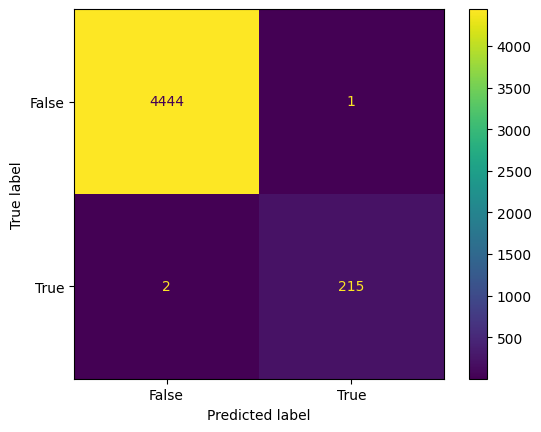

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv_edt.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_edt.best_estimator_, X_train, y_train)

In [28]:
import numpy as np
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv_edt.best_estimator_.named_steps["stack"].final_estimator_.coef_.flatten() # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         1.520034            27.004820
1        svc         3.381698            60.079022
2         nb         0.727018            12.916157


# Aplicaciones operaciones sobre test con los mejores modelos

                 False       True  accuracy    macro avg  weighted avg
precision     0.982691   0.634146  0.961567     0.808419      0.963628
recall        0.976544   0.702703  0.961567     0.839623      0.961567
f1-score      0.979608   0.666667  0.961567     0.823137      0.962492
support    1279.000000  74.000000  0.961567  1353.000000   1353.000000


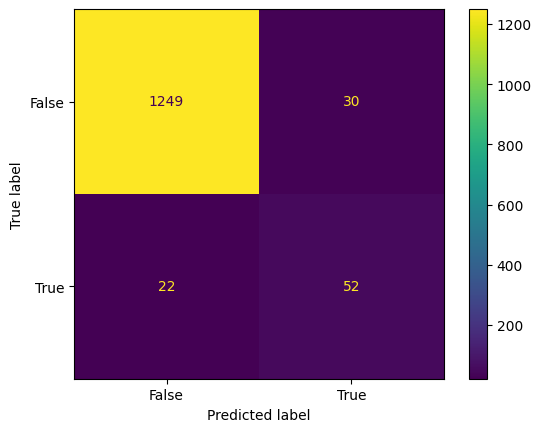

In [29]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
# feature_columns = MRMR
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 
chi_scores = chi2(x_train, y_train)
indexes = chi_scores[1] <= 0.05
columns = X_train.columns

X_test = X_test.loc[:, indexes]
ypred = cnn_chi.best_estimator_.predict(X_test)
print(pd.DataFrame(classification_report(y_test, ypred, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_chi.best_estimator_, X_test, y_test)

                 False       True  accuracy    macro avg  weighted avg
precision     0.993007   0.984848  0.992609     0.988928      0.992561
recall        0.999218   0.878378  0.992609     0.938798      0.992609
f1-score      0.996103   0.928571  0.992609     0.962337      0.992409
support    1279.000000  74.000000  0.992609  1353.000000   1353.000000


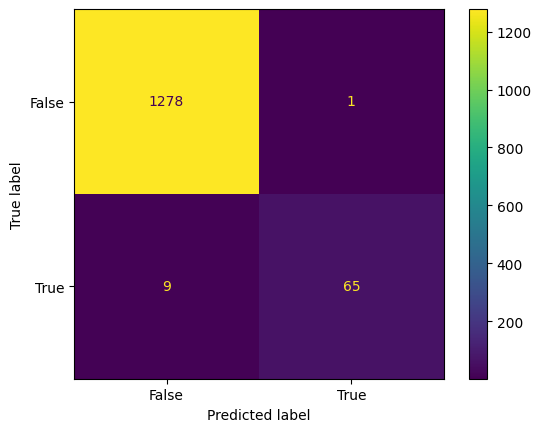

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred = scv_edt.best_estimator_.predict(X_test)
print(pd.DataFrame(classification_report(y_test, ypred, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_edt.best_estimator_, X_test, y_test)